# Модель машинного обучения для молочного хозяйства "Волный луг"

В данном проекте мне предостоит построить модель машинного обучения, которая поможет владельцу молочного хозяйства управлять рисками и принимать объективное решение о покупке коров. Он хочет купить новых буренок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. «ЭкоФерма» готова предоставить подробные данные о своих коровах.

Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
2. Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);

С помощью модели нужно отобрать коров по двум критериям:
- Средний удой за год — не менее 6000 килограммов,
- Молоко должно быть вкусным.

Хочется выделить ключевые этапы моей работы:
1. Загрузка и ознакомление с данными;
2. Предообработа данных;
3. Исследовательский анализ данных;
4. Проведение корреляционного анализа;
5. Обучение модели линейной регрессии
6. Обучение модели логистической регрессии
7. Подведение итогов

Описание данных: 

**Файл *ferma_main.csv* содержит данные о стаде фермера на текущий момент.**

**Описание таблицы:**
- Параметры корма коровы
- ЭКЕ (Энергетическая кормовая единица) — измерение питательности корма коровы;
- Сырой протеин — содержание сырого протеина в корме, в граммах;
- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
- Где паслась корова
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- Особенности коровы
- id — номер коровы;
- Порода — порода коровы;
- Возраст — бинарный признак (менее_2_лет, более_2_лет);
- Имя Папы — порода папы коровы.
- Характеристики молока
- Жирность — содержание жиров в молоке, в процентах;
- Белок — содержание белков в молоке, в процентах;
- Вкус молока — оценка вкуса по личным критериям фермера;
- Удой — масса молока, которую корова даёт в год, в килограммах.

**Файл *ferma_dad.csv* хранит имя папы каждой коровы в стаде фермера.**

**Файл *cow_buy.csv* — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Структура таблицы почти аналогична ferma_main.csv, кроме нескольких особенностей:**

- Белок и Жирность молока указаны на момент покупки — когда «ЭкоФерма» давала им свой корм.
- Параметры кормления ЭКЕ, Сырой протеин, СПО отсутствуют. Недавно технологи заказчика пересмотрели параметры корма и планируют их внедрить после расширения стада. Именно новые параметры нужно использовать, когда вы будете применять предсказательные модели к бурёнкам «ЭкоФермы». По новой схеме фермер планирует увеличить средние значения ЭКЕ, Сырой протеин, СПО на 5%.
- Удой и Вкус молока неизвестны — именно их и предстоит предсказать!

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score
)
import scipy.stats as st

In [3]:
def df_info(df):
    
    '''Данная ф-я выводит первичную информацию о датафрейме'''
    
    df.info()
    skip = df.isna().sum()
    dup = df.duplicated().sum()
    
    return print('\n' ,'Информация о пропусках:', skip, sep = '\n'), print('\n' ,'Кол-во дубликатов:', dup, sep = '\n')


In [4]:
def build_plot(df):
    
    """
    Данная ф-я выводит строит графики для колиественных признаков датафрейма
    """
    
    df.hist(figsize=(10, 12), ec='black', bins=10)
    plt.figure(figsize=(15, 7))
    count = 1
    for i in df.columns:
        if df[i].dtypes in ['int64', 'float64']:
            plt.subplot(2, 4, count)
            plt.title(i)
            plt.xlabel(i)
            plt.grid(True, alpha=0.5)
            sns.boxplot(data=df, y=df[i])
            count += 1
    plt.show()
    

In [5]:
RANDOM_STATE = 42

## Загрузка данных

### 1.1 Скачайте файлы и добавьте их датафреймы.

In [6]:
df_ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep = ';', decimal = ',')
df_ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep = ';', decimal = ',')
df_cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep = ';', decimal = ',')

### 1.2 Изучите признаки и данные.

In [7]:
df_ferma_main.head(15)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


Приведем столбцы к правильному виду

In [8]:
df_ferma_main = df_ferma_main.rename(columns={
    'Удой, кг': 'milk_yield', 
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit', 
    'Сырой протеин, г': 'raw_protein', 
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed', 
    'Тип пастбища': 'type_of_pasture',
    'порода папы_быка': 'breed_of_dad_bull', 
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein',
    'Вкус молока': 'taste_of_milk',
    'Возраст': 'age'
}) 

In [9]:
df_info(df_ferma_main)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   raw_protein          634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   type_of_pasture      634 non-null    object 
 7   breed_of_dad_bull    634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  taste_of_milk        634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Информация о пропусках:
id                     0
milk_yield             0
energy_feed_unit       0
raw_protein            0
sugar_

(None, None)

In [10]:
df_ferma_main.columns

Index(['id', 'milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'breed', 'type_of_pasture', 'breed_of_dad_bull',
       'fat_content', 'protein', 'taste_of_milk', 'age'],
      dtype='object')

In [11]:
df_ferma_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,634.0,317.460568,183.096982,1.000,159.250,317.500,475.750,629.000
milk_yield,634.0,6187.025237,1638.401021,5204.000,5751.750,6130.500,6501.000,45616.000
energy_feed_unit,634.0,14.542744,1.301301,10.900,13.500,14.700,15.600,16.800
raw_protein,634.0,1922.682965,182.392548,1660.000,1772.250,1880.500,2058.750,2349.000
sugar_protein_ratio,634.0,0.912855,0.032209,0.840,0.890,0.930,0.940,0.960
fat_content,634.0,3.603943,0.168020,2.990,3.590,3.650,3.720,3.750
protein,634.0,3.075666,0.002540,3.069,3.074,3.076,3.077,3.085


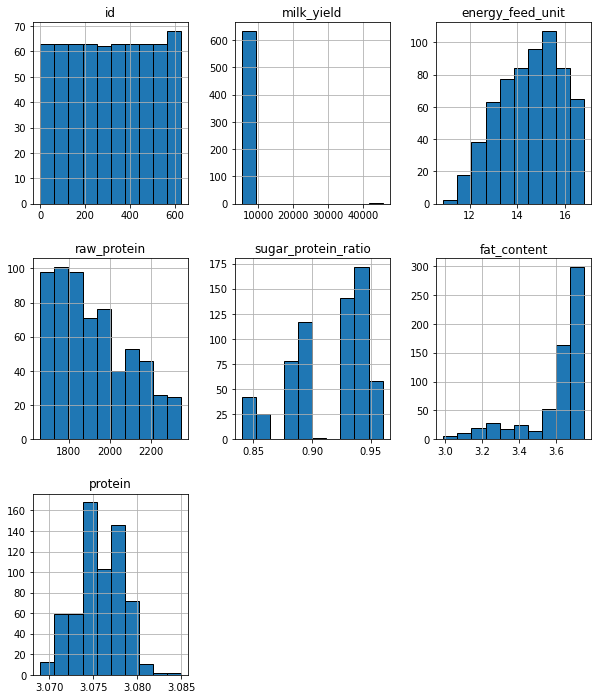

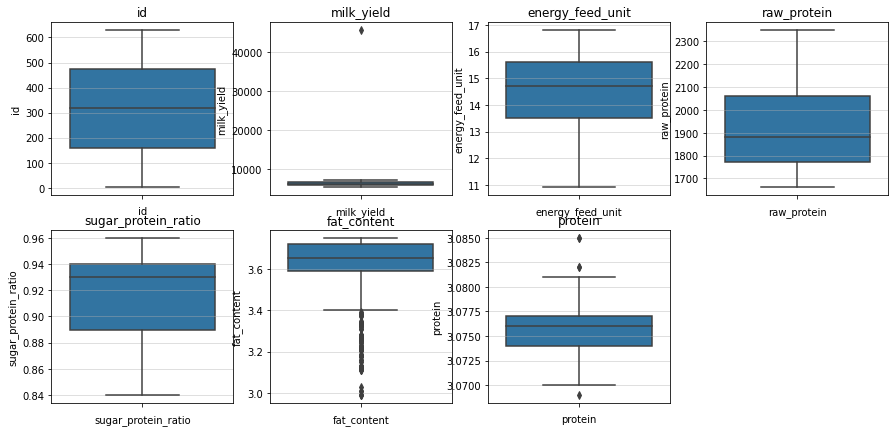

In [12]:
build_plot(df_ferma_main)

In [13]:
df_ferma_dad.head(15)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [14]:
df_ferma_dad = df_ferma_dad.rename(columns={
    'Имя Папы': 'name_dad'
})

In [15]:
df_ferma_dad.columns

Index(['id', 'name_dad'], dtype='object')

In [16]:
df_info(df_ferma_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   name_dad  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Информация о пропусках:
id          0
name_dad    0
dtype: int64


Кол-во дубликатов:
0


(None, None)

In [17]:
df_cow_buy.head(15)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


In [18]:
df_cow_buy = df_cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'type_of_pasture', 
    'порода папы_быка': 'breed_of_dad_bull', 
    'Имя_папы': 'name_dad', 
    'Текущая_жирность,%': 'current_fatness',
    'Текущий_уровень_белок,%': 'current_level_of_the_protein',
    'Возраст': 'age',
})

In [19]:
df_cow_buy.columns

Index(['breed', 'type_of_pasture', 'breed_of_dad_bull', 'name_dad',
       'current_fatness', 'current_level_of_the_protein', 'age'],
      dtype='object')

In [20]:
df_info(df_cow_buy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   breed                         20 non-null     object 
 1   type_of_pasture               20 non-null     object 
 2   breed_of_dad_bull             20 non-null     object 
 3   name_dad                      20 non-null     object 
 4   current_fatness               20 non-null     float64
 5   current_level_of_the_protein  20 non-null     float64
 6   age                           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Информация о пропусках:
breed                           0
type_of_pasture                 0
breed_of_dad_bull               0
name_dad                        0
current_fatness                 0
current_level_of_the_protein    0
age                             0
dtype: int64


Кол-во дубликатов:
4


(None, None)

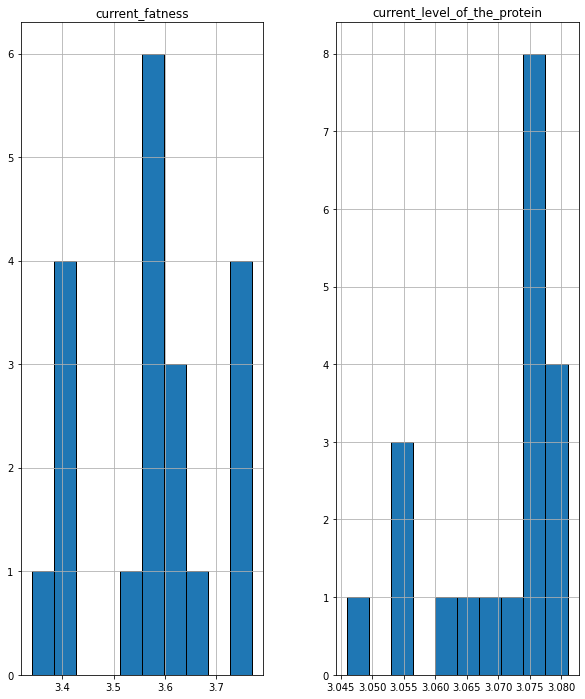

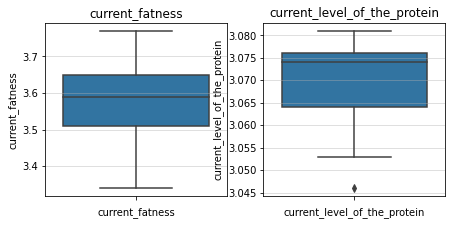

In [21]:
build_plot(df_cow_buy)

По итогам ознакомления можно сделать следующие выводы:
- Столбцы имели некорректный формат наиманования. Были перемименованы.
- Дубликаты обнаружены в датафремах: df_ferma_main, df_cow_buy
- В числовых признаках чаще всего встречается тип переменной "objects". Необходимо будет для чисел с плавающей точкой выставить тип переменных "float".
- В датафремах пропусков не обнаружено

##  Предобработка данных

## 2.1 Удаление дубликатов

In [22]:
df_ferma_main.duplicated().sum()

5

In [23]:
df_ferma_main[df_ferma_main.duplicated() == True]

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [24]:
df_ferma_main = df_ferma_main.drop_duplicates().reset_index(drop = True)

In [25]:
df_ferma_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [26]:
df_ferma_main['type_of_pasture'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Обнаружил неявный дубликат.

In [27]:
df_ferma_main['type_of_pasture'] = df_ferma_main['type_of_pasture'].replace('Равнинные', 'Равнинное')

In [28]:
df_ferma_main['type_of_pasture'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

Дубликаты устараенны

In [29]:
df_ferma_main['breed_of_dad_bull'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [30]:
df_ferma_main['breed_of_dad_bull'] = df_ferma_main['breed_of_dad_bull'].replace('Айдиалл', 'Айдиал')

In [31]:
df_ferma_main['breed_of_dad_bull'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [32]:
df_ferma_main['taste_of_milk'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [33]:
df_ferma_main['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [34]:
df_cow_buy.duplicated().sum()

4

In [35]:
df_cow_buy[df_cow_buy.duplicated() == True]

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Стоит удалить эти дубликаты. 

In [36]:
df_cow_buy = df_cow_buy.drop_duplicates().reset_index(drop = True)

In [37]:
df_cow_buy

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет


In [38]:
df_cow_buy['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [39]:
df_cow_buy['type_of_pasture'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [40]:
df_cow_buy['breed_of_dad_bull'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [41]:
df_cow_buy['name_dad'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [42]:
df_cow_buy['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [43]:
df_ferma_dad.duplicated().sum()

0

Удаление и обработка дубликатов прошла успешно

## Исследовательский анализ данных

### 3.1 Проведите статистический анализ всех признаков.

В данном пункте я планирую провести описательную статистику всех данных нам признаков.

In [44]:
df_ferma_main.describe().T

,count,mean,std,min,25%,50%,75%,max
id,629.0,315.000000,181.720940,1.000,158.000,315.000,472.000,629.000
milk_yield,629.0,6188.750397,1644.795489,5204.000,5751.000,6133.000,6501.000,45616.000
energy_feed_unit,629.0,14.543879,1.306408,10.900,13.500,14.700,15.600,16.800
raw_protein,629.0,1923.364070,182.956251,1660.000,1771.000,1888.000,2062.000,2349.000
sugar_protein_ratio,629.0,0.913116,0.032203,0.840,0.890,0.930,0.940,0.960
fat_content,629.0,3.603657,0.168656,2.990,3.590,3.650,3.720,3.750
protein,629.0,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


In [45]:
type_of_pasture_main = df_ferma_main['type_of_pasture'].value_counts()
type_of_pasture_main

Холмистое    351
Равнинное    278
Name: type_of_pasture, dtype: int64

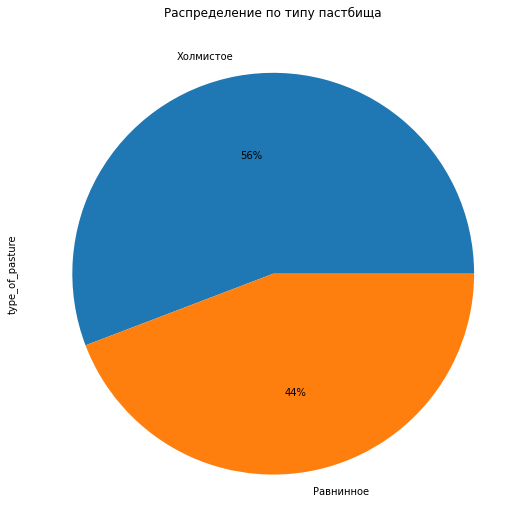

In [46]:
df_ferma_main['type_of_pasture'].value_counts().plot(kind='pie', y = type_of_pasture_main, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по типу пастбища')
plt.show()

In [47]:
breed_main = df_ferma_main['breed'].value_counts()
breed_main

Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: breed, dtype: int64

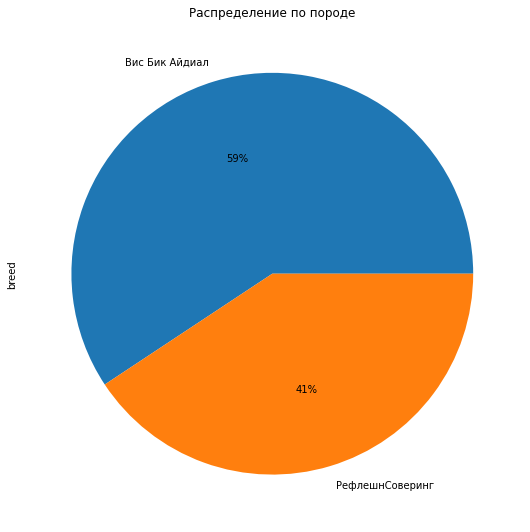

In [48]:
df_ferma_main['breed'].value_counts().plot(kind='pie', y = breed_main, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по породе')
plt.show()

In [49]:
breed_of_dad_bull_main = df_ferma_main['breed_of_dad_bull'].value_counts()
breed_of_dad_bull_main

Айдиал     318
Соверин    311
Name: breed_of_dad_bull, dtype: int64

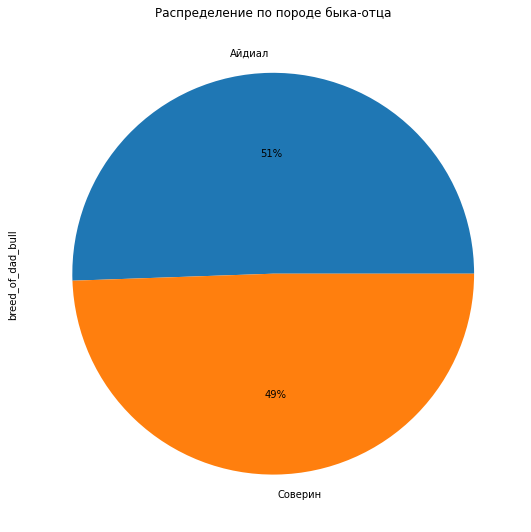

In [50]:
df_ferma_main['breed_of_dad_bull'].value_counts().plot(kind='pie', y = breed_of_dad_bull_main, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по породе быка-отца')
plt.show()

In [51]:
taste_milk_main = df_ferma_main['taste_of_milk'].value_counts()
taste_milk_main

вкусно       371
не вкусно    258
Name: taste_of_milk, dtype: int64

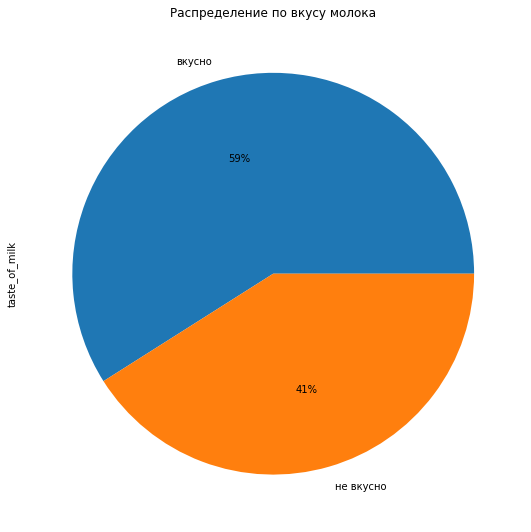

In [52]:
df_ferma_main['taste_of_milk'].value_counts().plot(kind='pie', y = taste_milk_main, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по вкусу молока')
plt.show()

In [53]:
age_main = df_ferma_main['age'].value_counts()
age_main

более_2_лет    519
менее_2_лет    110
Name: age, dtype: int64

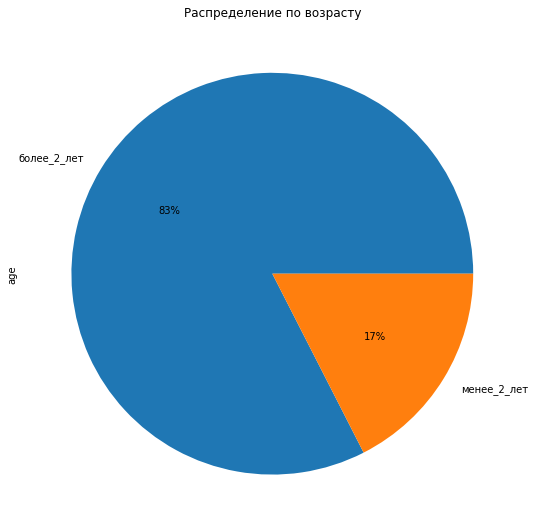

In [54]:
df_ferma_main['age'].value_counts().plot(kind='pie', y = age_main, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по возрасту')
plt.show()

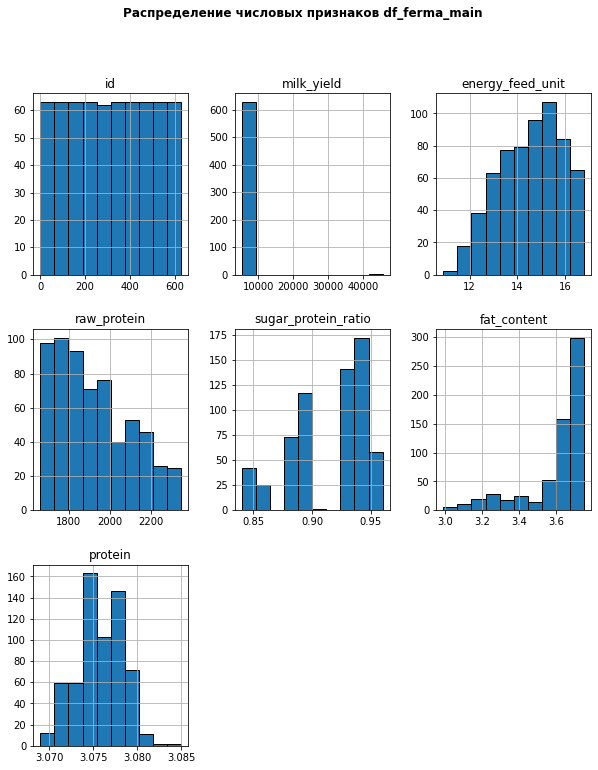

In [55]:
df_ferma_main.hist(figsize=(10, 12), ec='black', bins=10)
plt.suptitle('Распределение числовых признаков df_ferma_main',  fontweight='bold')
plt.show()

Необходимо проверить данные на выбросы

<Figure size 432x288 with 0 Axes>

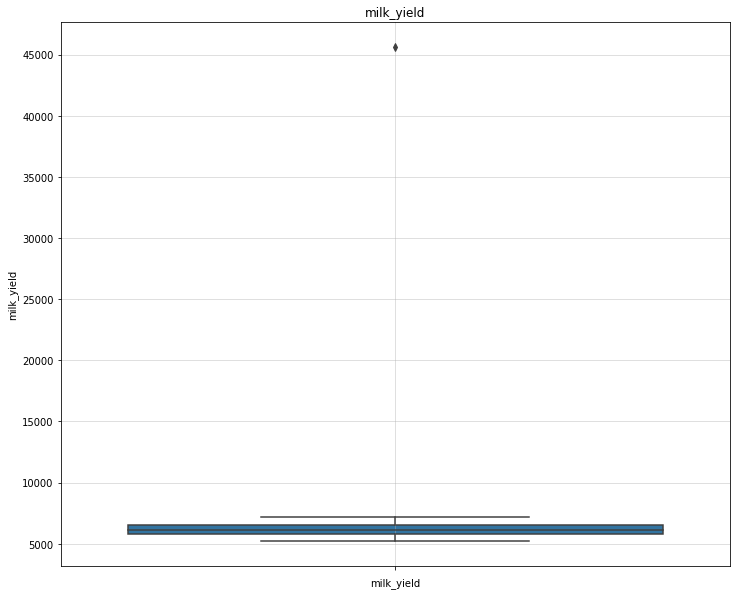

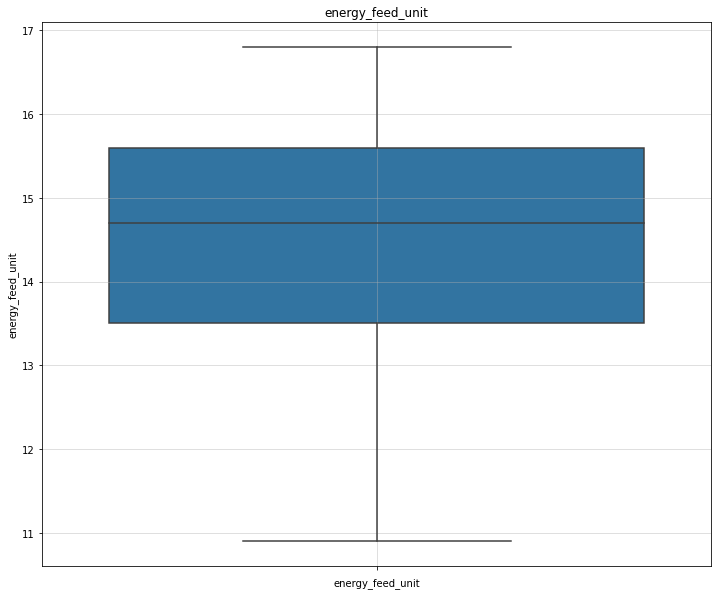

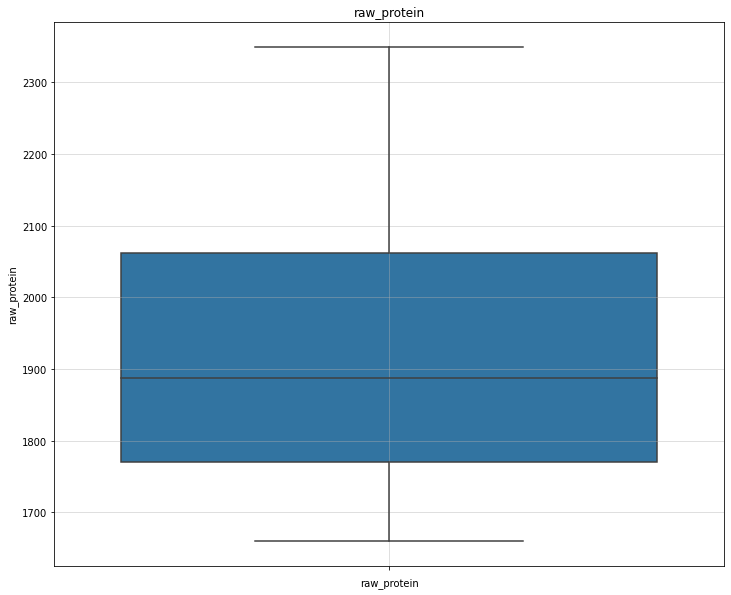

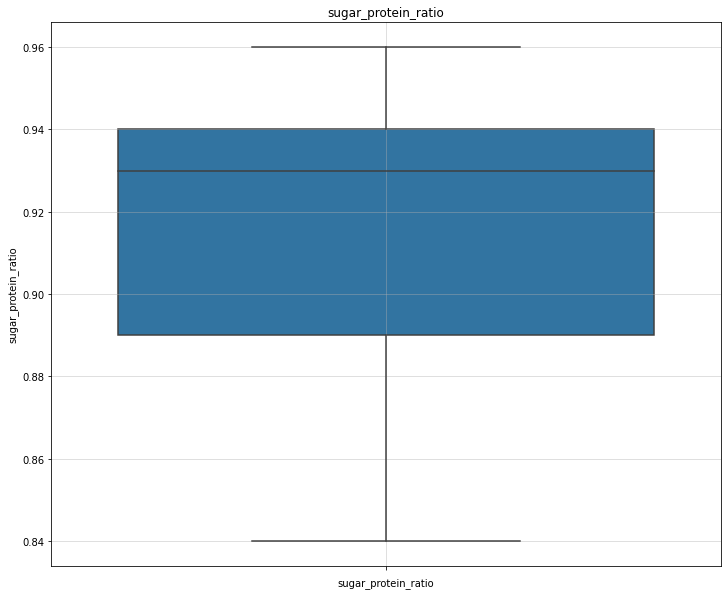

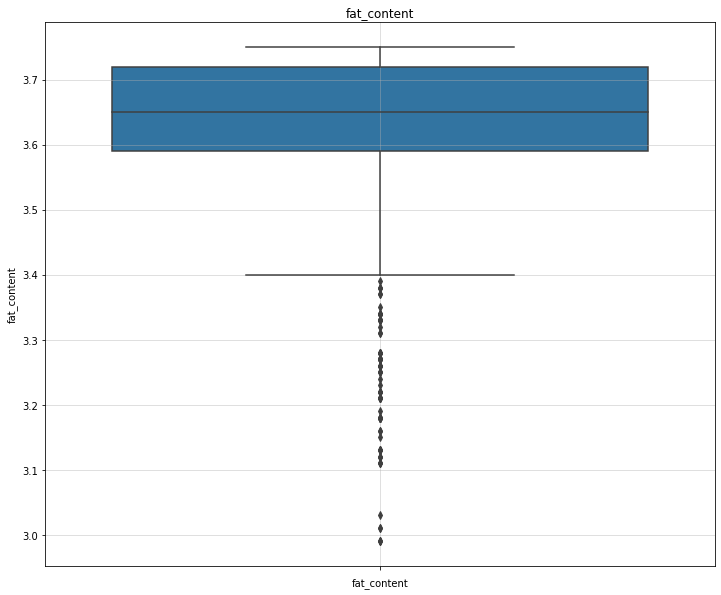

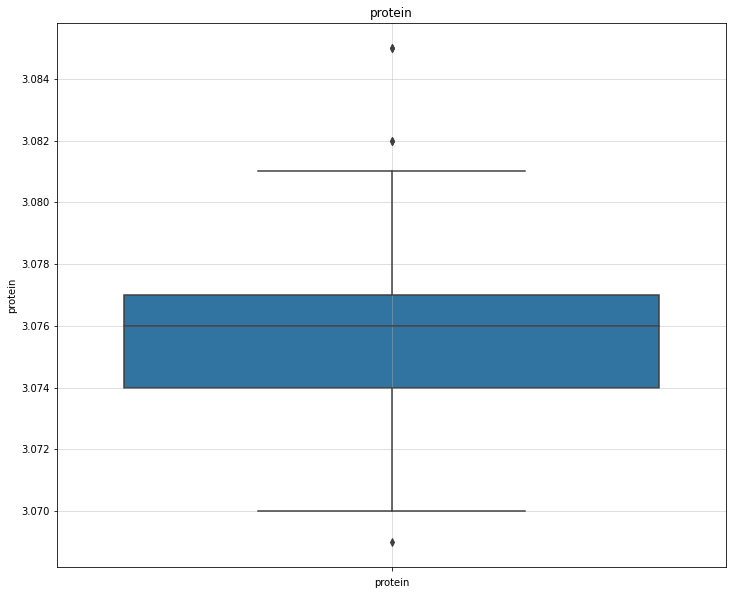

In [56]:
name = ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']
plt.suptitle('Боксплот числовых признаков df_ferma_main',  fontweight='bold')    
for i in name:
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=df_ferma_main, y=df_ferma_main[i])
    plt.title(i)
    plt.xlabel(i)
    plt.grid(True, alpha=0.5)
plt.show()

**Первичные выводы по статистическому анализу df_ferma_main:**

Категориальные данные

- Коровы в основном пасутся на холмитсых пастбищах
- Самая распостроненная порода Вис Бик Айдиал
- Породы быка отца распределены практически 50 на 50. На один процент чаще встречается порода Айдиал
- Молоко чаще всего получается "вкусное"
- В таблице значительно пребладют коровы, которые старше 2 лет

Количественные даннные
- Явный выброс имеется в поле milk_yield. Проверим этот выброс
- Видны пики в поле к концу графика в поле "fat_content". Проверим эти выбросы
- Распределение значений в поле "raw_protein" явно смещенно влево
- Обратил внимание, что в поле "sugar_protein_ratio" данные распределены на три группы. Думаю, что можно улушить данные, категоризировав данный количественный признак. 
- Так же обратил внимание, что данные имеют ненормальное распределение и смещены относительно цента графика.

Необходимо проверить выброс в поле milk_yield

In [57]:
df_ferma_main[df_ferma_main['milk_yield'] > 8000]

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


Видно, что данное кол-во удоя сильно нереалистичное по сравнению с остальными данными. Думаю, что причиной такого выброса  является человеский фактор. 
Стоит удалить данный показатель.

In [58]:
df_ferma_main = df_ferma_main[df_ferma_main['milk_yield'] <= 8000]

In [59]:
df_ferma_dad = df_ferma_dad.drop(index = [16]).reset_index(drop = True)

In [60]:
df_ferma_main.head(20)

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


Чтобы спокойно избавиться от выбросов в поле fat_content необходимо узнать их процент 

In [61]:
len(df_ferma_main[df_ferma_main['fat_content'] < 3.3]) / len(df_ferma_main) * 100

9.872611464968154

10 % Значительное кол-во для нашеей выборки. Думаю, что их стоит сохранить для более качественного построения модели.

Проверим результаты.

<Figure size 432x288 with 0 Axes>

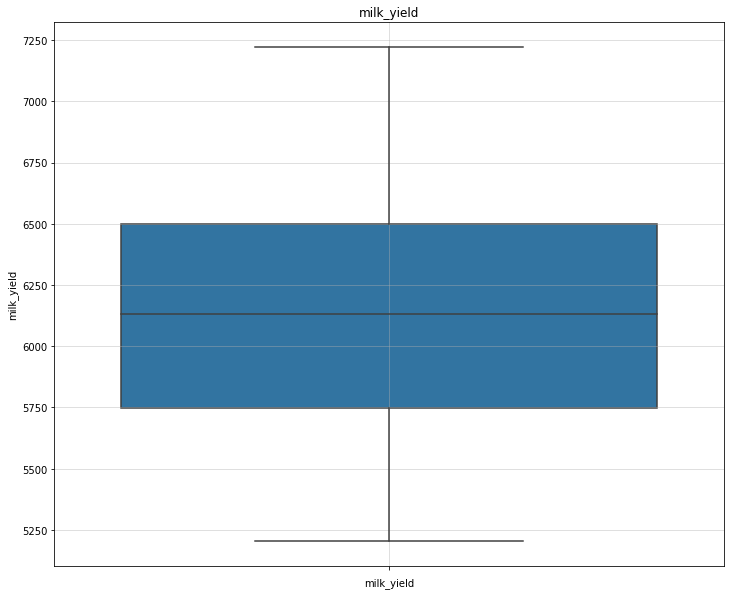

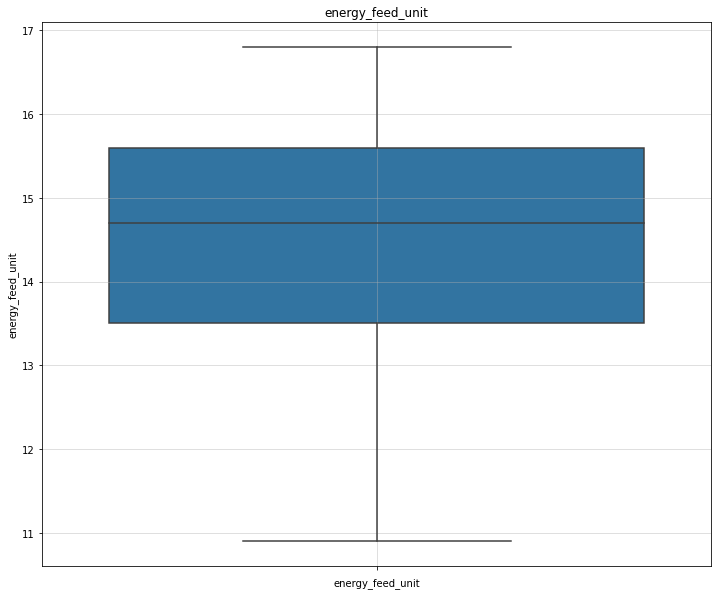

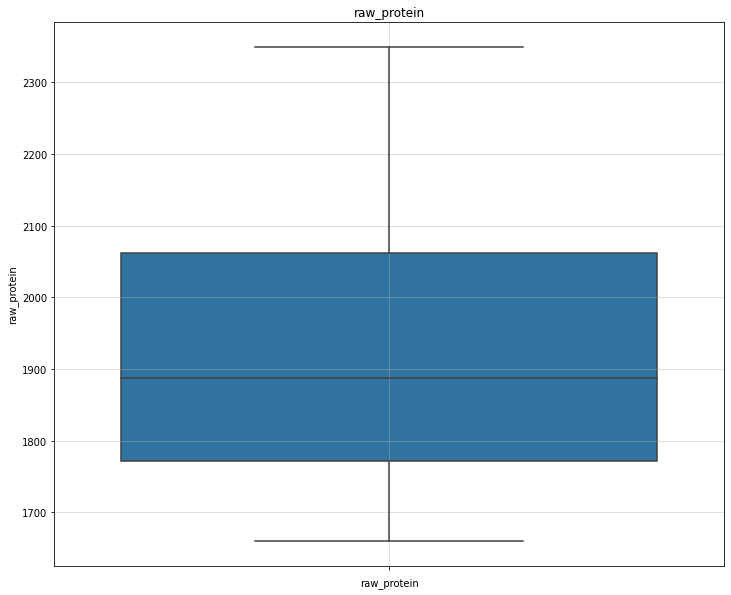

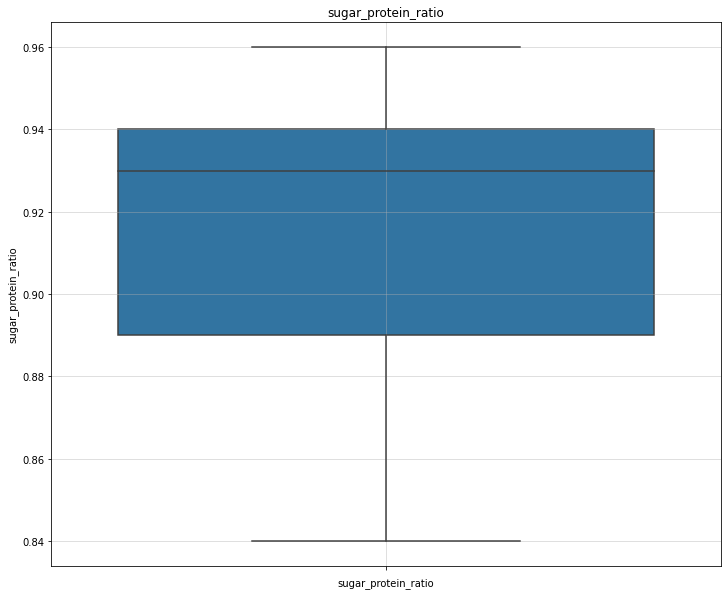

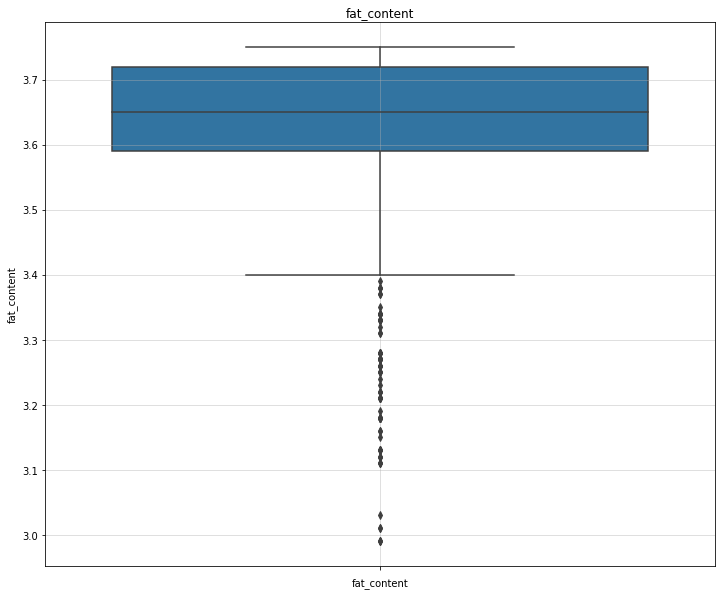

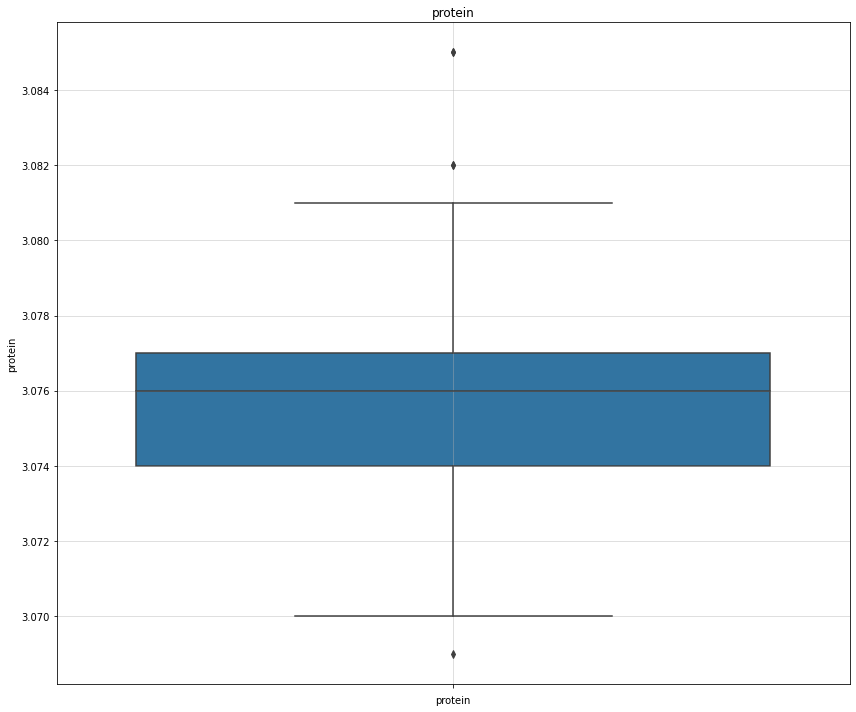

In [62]:
name = ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']
plt.suptitle('Боксплот числовых признаков df_ferma_main',  fontweight='bold')    
for i in name:
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=df_ferma_main, y=df_ferma_main[i])
    plt.title(i)
    plt.xlabel(i)
    plt.grid(True, alpha=0.5)
plt.tight_layout()    
plt.show()

Явные выбросы устранены.

In [63]:
df_cow_buy.describe().T

,count,mean,std,min,25%,50%,75%,max
current_fatness,16.0,3.571875,0.141620,3.340,3.4150,3.5850,3.69250,3.770
current_level_of_the_protein,16.0,3.068250,0.011264,3.046,3.0595,3.0735,3.07675,3.081


In [64]:
breed_buy = df_cow_buy['breed'].value_counts()
breed_buy

Вис Бик Айдиал     8
РефлешнСоверинг    8
Name: breed, dtype: int64

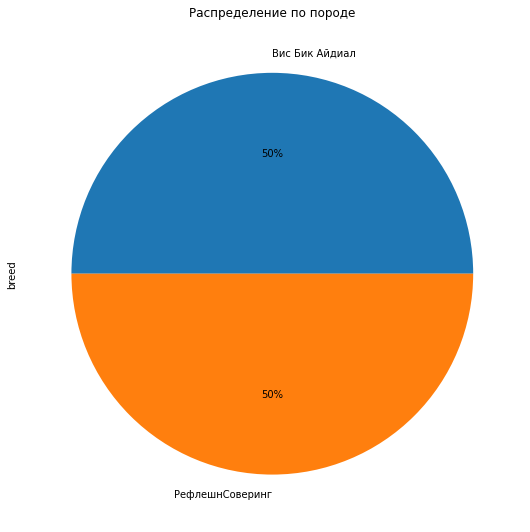

In [65]:
df_cow_buy['breed'].value_counts().plot(kind='pie', y = breed_buy, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по породе')
plt.show()

In [66]:
type_of_pasture_buy = df_cow_buy['type_of_pasture'].value_counts()
type_of_pasture_buy

холмистое    8
равнинное    8
Name: type_of_pasture, dtype: int64

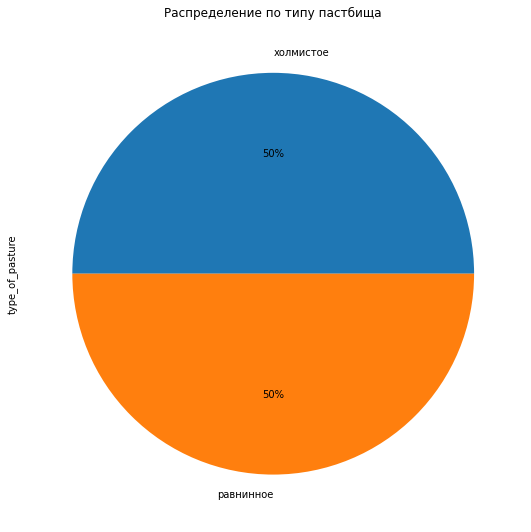

In [67]:
df_cow_buy['type_of_pasture'].value_counts().plot(kind='pie', y = type_of_pasture_buy, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по типу пастбища')
plt.show()

In [68]:
breed_of_dad_bull_buy = df_cow_buy['breed_of_dad_bull'].value_counts()
breed_of_dad_bull_buy

Соверин    10
Айдиал      6
Name: breed_of_dad_bull, dtype: int64

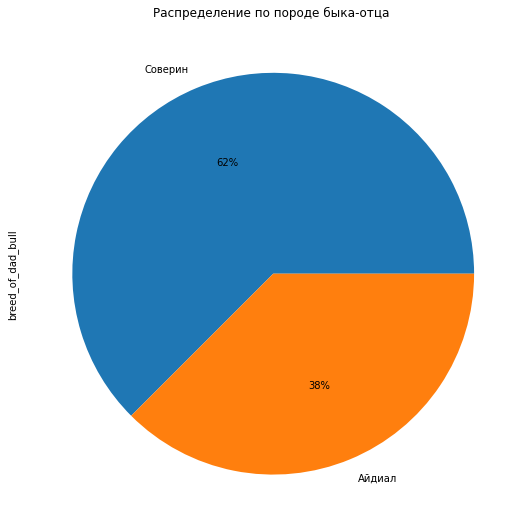

In [69]:
df_cow_buy['breed_of_dad_bull'].value_counts().plot(kind='pie', y = breed_of_dad_bull_buy, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по породе быка-отца ')
plt.show()

In [70]:
age_buy = df_cow_buy['age'].value_counts()
age_buy

более_2_лет    11
менее_2_лет     5
Name: age, dtype: int64

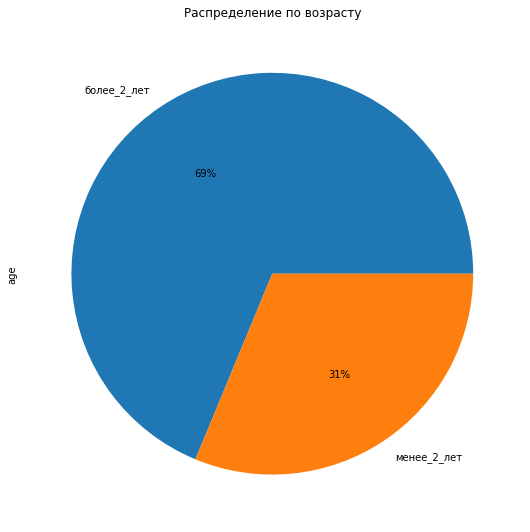

In [71]:
df_cow_buy['age'].value_counts().plot(kind='pie', y = age_buy, figsize = (9, 10), autopct = '%1.0f%%', grid=True, title='Распределение по возрасту')
plt.show()

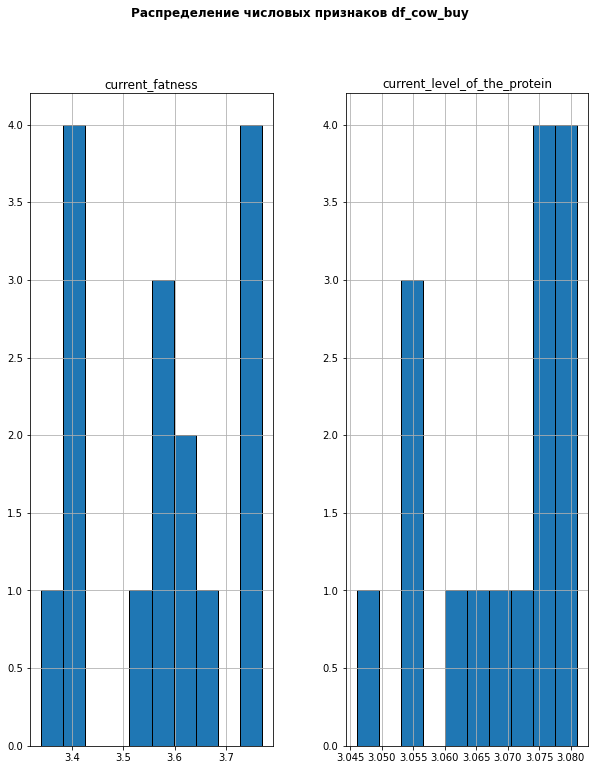

In [72]:
df_cow_buy.hist(figsize=(10, 12), ec='black', bins=10)
plt.suptitle('Распределение числовых признаков df_cow_buy',  fontweight='bold')
plt.show()

<Figure size 432x288 with 0 Axes>

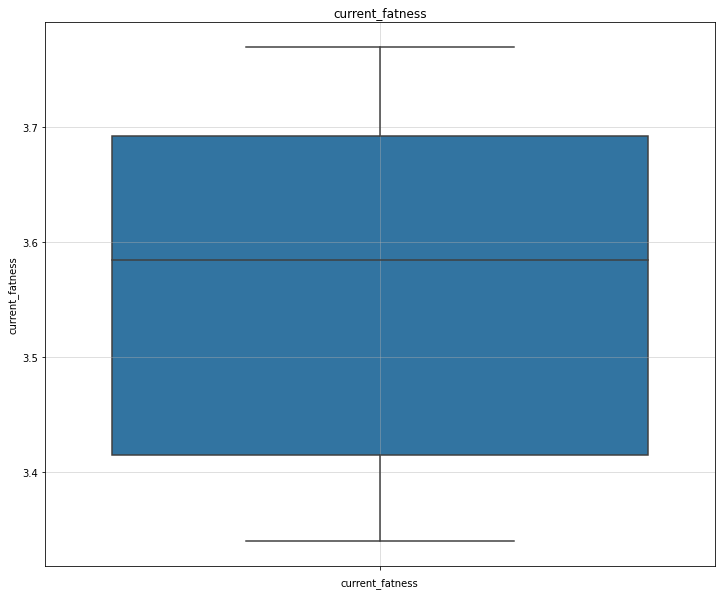

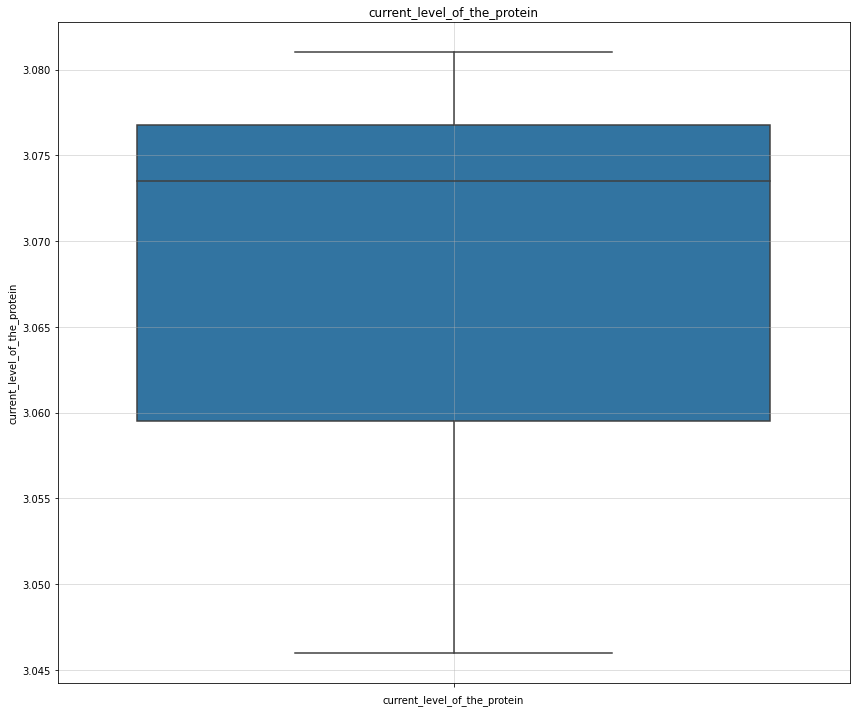

In [73]:
name = ['current_fatness', 'current_level_of_the_protein']
plt.suptitle('Боксплот числовых признаков df_cow_buy',  fontweight='bold')    
for i in name:
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=df_cow_buy, y=df_cow_buy[i])
    plt.title(i)
    plt.xlabel(i)
    plt.grid(True, alpha=0.5)
plt.tight_layout()    
plt.show()

**Первичные выводы по статистическому анализу df_cow_buy:**

Категориальные данные

- В данном списке коров больше коров с породой РефлешнСоверинг
- Коровы чаще пасутся на равнинных пастбищах
- В поле "Порода быка-отца" чаще встречается порода "Соверин"
- Значительно больше коров, которые старше двух лет

Количественные даннные

- Самый распостроненный показатель жирности в данной выборке 3.6 % 
- Большинство молока получается с содержанием белка больше 3.07

## Корреляционный анализ

Для более качественного проведения анализа, мне кажется, стоит соединить таблицу с информацией о коровах фермера и имене отца всех коров.

In [74]:
df_ferma_dad.sample(10)

,id,name_dad
545,547,Барин
585,587,Буйный
269,271,Барин
506,508,Буйный
312,314,Буйный
505,507,Буйный
587,589,Барин
222,224,Геркулес
105,107,Барин
136,138,Буйный


In [75]:
df_ferma_main.sample(10)

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age
351,352,6734,16.3,1767,0.940,Вис Бик Айдиал,Равнинное,Айдиал,3.73,3.074,не вкусно,более_2_лет
599,600,6968,16.4,2041,0.950,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.075,вкусно,более_2_лет
407,408,5392,11.9,1827,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.59,3.078,вкусно,менее_2_лет
24,25,5372,13.2,1703,0.895,Вис Бик Айдиал,Равнинное,Айдиал,3.31,3.078,не вкусно,менее_2_лет
330,331,5989,13.6,1913,0.880,Вис Бик Айдиал,Равнинное,Соверин,3.72,3.074,вкусно,более_2_лет
590,591,6081,15.0,1868,0.940,Вис Бик Айдиал,Холмистое,Айдиал,3.64,3.080,вкусно,более_2_лет
400,401,5887,14.2,1877,0.890,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,вкусно,более_2_лет
216,217,6704,14.2,1800,0.930,Вис Бик Айдиал,Холмистое,Айдиал,3.71,3.072,не вкусно,более_2_лет
371,372,6592,15.4,1810,0.930,РефлешнСоверинг,Равнинное,Айдиал,3.72,3.073,не вкусно,более_2_лет
357,358,6617,15.4,1729,0.930,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.074,не вкусно,более_2_лет


In [76]:
df_ferma_main.merge(df_ferma_dad, on = 'id', how = 'left')

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age,name_dad
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
624,626,5513,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
625,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин
626,628,5746,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Барин


In [77]:
df_ferma_main = df_ferma_main.merge(df_ferma_dad, on = 'id', how = 'inner')

In [78]:
df_ferma_main.head(15)

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age,name_dad
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет,Барин
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.48,3.077,вкусно,более_2_лет,Соловчик
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет,Геркулес
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет,Буйный
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет,Барин


### Изучения корреляции целевого признака "Удой"

 #### Корреляция для количественных признаков.

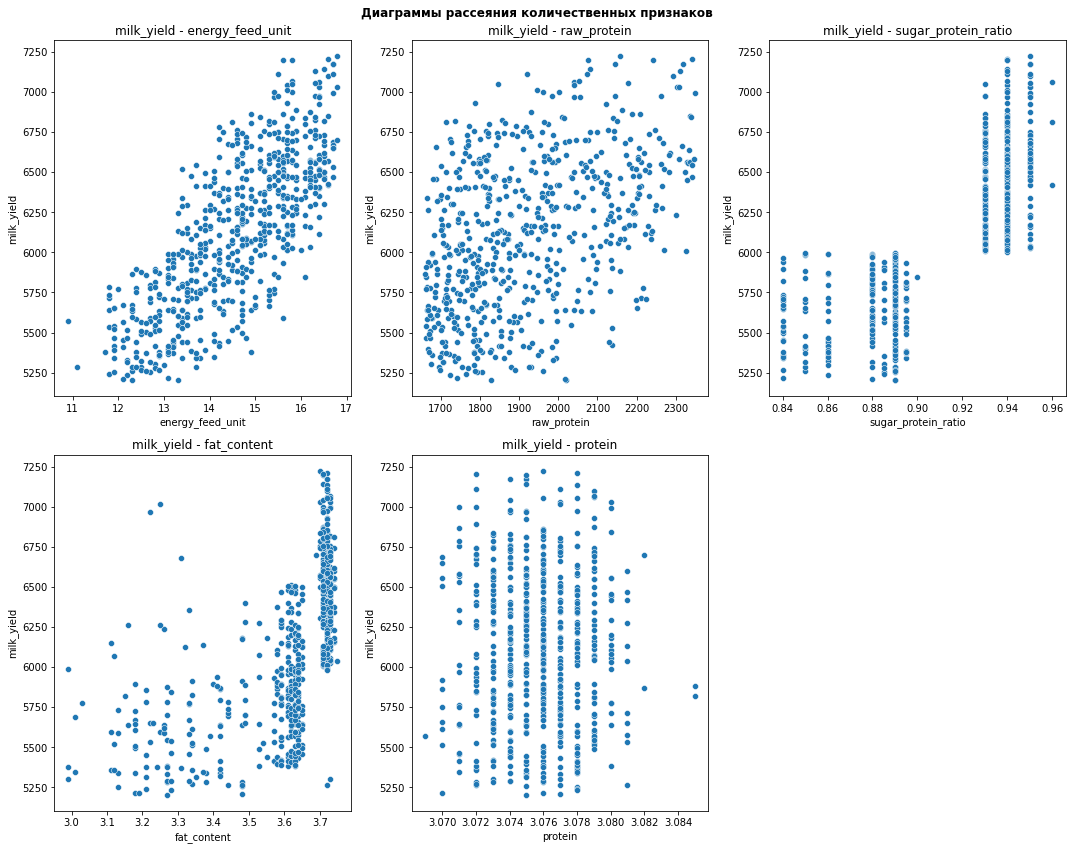

In [79]:
count = 1
columns = ['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']
plt.figure(figsize=(15,12))
plt.suptitle('Диаграммы рассеяния количественных признаков', fontweight='bold')
for i in columns:
    plt.subplot(2, 3, count)
    plt.title(f'milk_yield - {i}')
    sns.scatterplot(data=df_ferma_main, x=df_ferma_main[i], y='milk_yield')
    count += 1
plt.tight_layout()
plt.show()

Посчитаем корреляцию Спирмена, т.к. количественные признаки имеют асимметричное распределение.

In [80]:
corr_sp = df_ferma_main[['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']].corr()
corr_sp

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,fat_content,protein
milk_yield,1.000000,0.765098,0.446731,0.806339,0.600902,0.002966
energy_feed_unit,0.765098,1.000000,0.387875,0.749007,0.637279,-0.008939
raw_protein,0.446731,0.387875,1.000000,0.446332,0.357793,0.226802
sugar_protein_ratio,0.806339,0.749007,0.446332,1.000000,0.629098,0.073718
fat_content,0.600902,0.637279,0.357793,0.629098,1.000000,-0.026542
protein,0.002966,-0.008939,0.226802,0.073718,-0.026542,1.000000


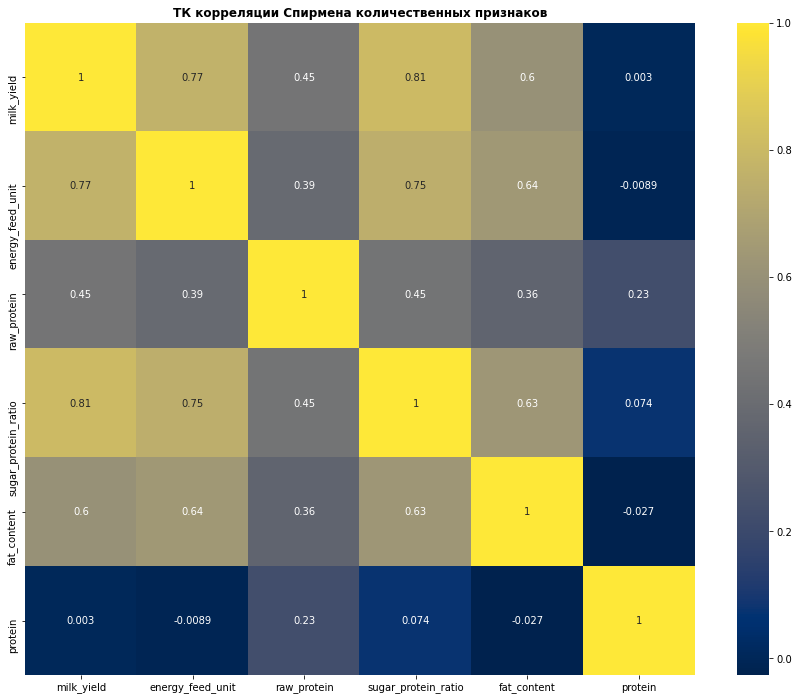

In [81]:
plt.figure(figsize = (15, 12))
plt.title('ТК корреляции Спирмена количественных признаков', fontweight='bold')
sns.heatmap(corr_sp, annot=True, cmap='cividis') 
plt.show()

- По данной тепловой карте видно, что явная корреляция нашего целевого признка присутствует с полями "energy_feed_unit" и "sugar_protein_ratio".

- По графикам scatterplot можем заметить, что взаимосвязь показателей "milk_yield", "energy_feed_unit" и "sugar_protein_ratio" является нелинейной.

 #### Корреляция для качественных признаков.

In [82]:
phik_corr = df_ferma_main[['milk_yield', 'breed', 'type_of_pasture', 'breed_of_dad_bull', 'taste_of_milk', 'age', 'name_dad']].phik_matrix()
phik_corr

interval columns not set, guessing: ['milk_yield']


,milk_yield,breed,type_of_pasture,breed_of_dad_bull,taste_of_milk,age,name_dad
milk_yield,1.000000,0.164744,0.279540,0.519915,0.173122,0.998101,0.433409
breed,0.164744,1.000000,0.213218,0.089330,0.000000,0.057295,0.382644
type_of_pasture,0.279540,0.213218,1.000000,0.000000,0.269063,0.128455,0.233149
breed_of_dad_bull,0.519915,0.089330,0.000000,1.000000,0.000000,0.355817,0.982909
taste_of_milk,0.173122,0.000000,0.269063,0.000000,1.000000,0.165974,0.000000
age,0.998101,0.057295,0.128455,0.355817,0.165974,1.000000,0.390603
name_dad,0.433409,0.382644,0.233149,0.982909,0.000000,0.390603,1.000000


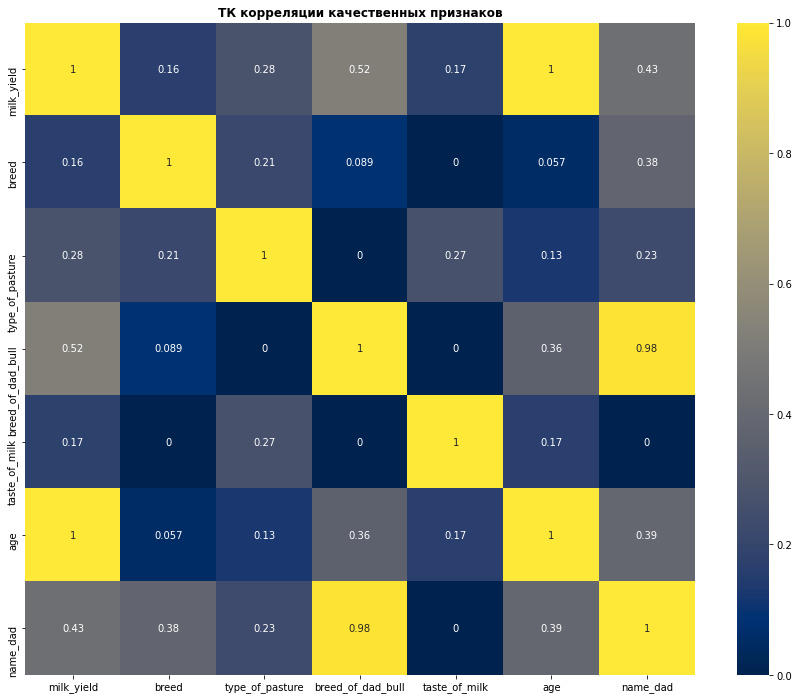

In [83]:
plt.figure(figsize = (15, 12))
plt.title('ТК корреляции качественных признаков', fontweight='bold')
sns.heatmap(phik_corr, annot=True, cmap='cividis') 
plt.show()

Видим, что целевой признак явно коррелирует с качественным признаком "age". 

### Изучения корреляции целевого признака "Вкус молока"

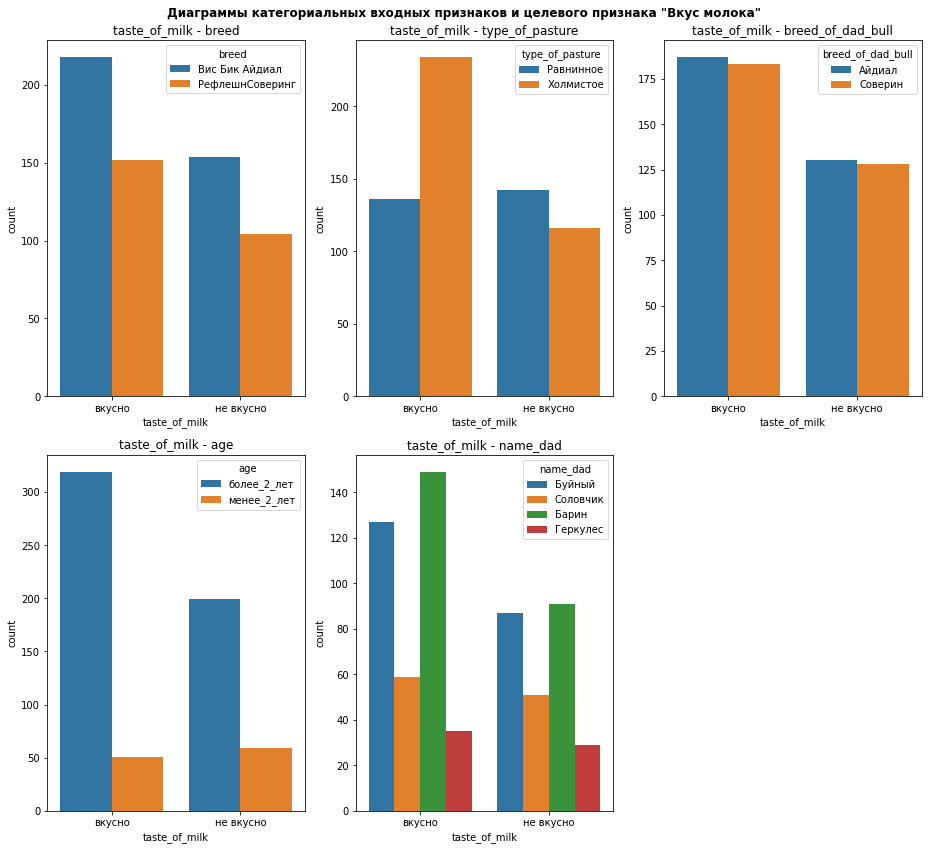

In [84]:
count = 1
columns = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'age', 'name_dad']
plt.figure(figsize=(13,12))
plt.suptitle('Диаграммы категориальных входных признаков и целевого признака "Вкус молока"', fontweight='bold')
for i in columns:
    plt.subplot(2, 3, count)
    plt.title(f'taste_of_milk - {i}')
    sns.countplot(x = 'taste_of_milk', hue = i, data = df_ferma_main)
    count += 1
plt.tight_layout()
plt.show()

Выше построенный график нам говороит о следующих фактах:

- Порода коров, которая дает больше вкусного молока является "Вис Бик Айдиал"
- Чаще всего вкусно молоко получается у тех коров, которые имеют тип пастбища "Холмистое"
- Показатели обоих пород отцов-быков в случаях, когда молоко получается вкусным практически равнозначны.
- У коров старше двух лет почти всего получаетя вкуснее. Я думаю, в данном случае влияет то, что таких коров сильно больше, чем тех, которые младше двух лет
- Больше вкусного молока получается у потомков Барина и Буйного.

Воспользуемся корреляцией Спирмена для исследования взаимосвязи у данных показателей.

In [85]:
phik_corr_t_o_m = df_ferma_main.iloc[:, 1:].phik_matrix()
phik_corr_t_o_m

interval columns not set, guessing: ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']


,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age,name_dad
milk_yield,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.519915,0.707654,0.058970,0.173122,0.998101,0.433409
energy_feed_unit,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.171355,0.715914,0.000000,0.272265,0.771596,0.069197
raw_protein,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685,0.111229
sugar_protein_ratio,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.425601,0.645581,0.073787,0.572702,0.744410,0.409142
breed,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.089330,0.222825,0.361851,0.000000,0.057295,0.382644
type_of_pasture,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.000000,0.000000,0.099908,0.269063,0.128455,0.233149
breed_of_dad_bull,0.519915,0.171355,0.000000,0.425601,0.089330,0.000000,1.000000,0.000000,0.134582,0.000000,0.355817,0.982909
fat_content,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.000000,1.000000,0.000000,0.198793,0.677913,0.090409
protein,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.134582,0.000000,1.000000,0.143857,0.000000,0.091102
taste_of_milk,0.173122,0.272265,0.176480,0.572702,0.000000,0.269063,0.000000,0.198793,0.143857,1.000000,0.165974,0.000000


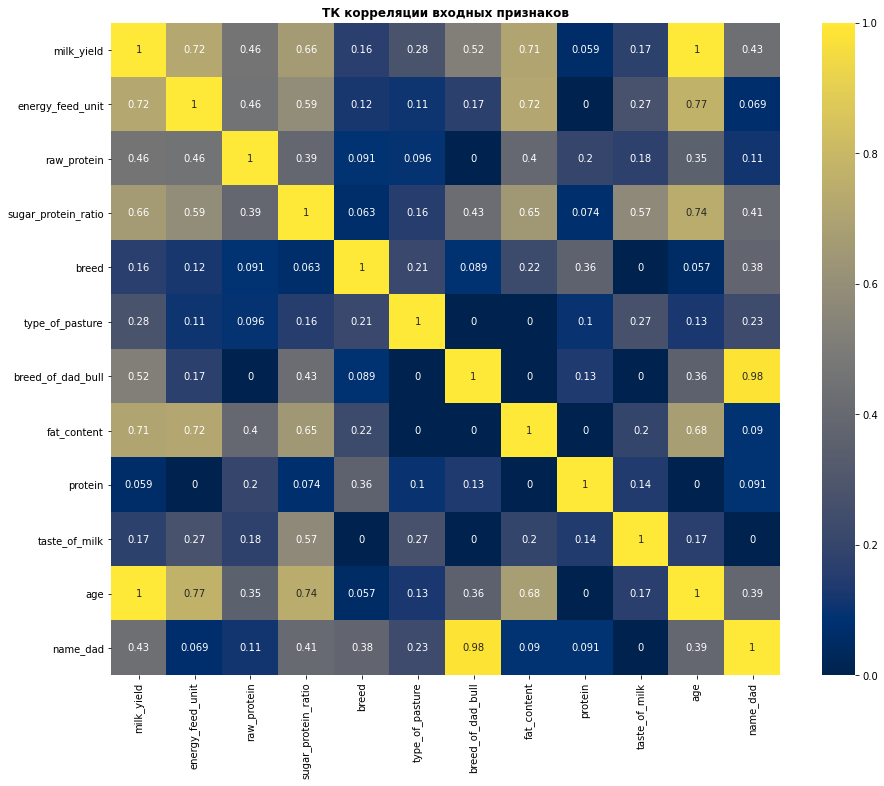

In [86]:
plt.figure(figsize = (15, 12))
plt.title('ТК корреляции входных признаков', fontweight='bold')
sns.heatmap(phik_corr_t_o_m, annot=True, cmap='cividis') 
plt.show()

Более явная корреляция целевого признака "Вкус молока" наблюдается только с входным признаком "sugar_protein_ratio". 

Для исключения нейлинейной зависимости целевого признака "Удой" с входными признаками  "energy_feed_unit" и "sugar_protein_ratio" в будующем сделаем следующие действия: 

1) Переведем показаль "sugar_protein_ratio" в категориальный признак

2) energy_feed_unit возведем в квадарат и получим новый показаетель

Мультиколлениарности в нашем исследовании обнаружено не было.

## Обучение модели линейной регрессии

### Постройте модель линейной регрессии на данных датасета farm_main.csv

Целевой признак - Удой 	(milk_yield)

Для обучения буде использовать входные признаки, которые могут повлиять на удой. В данном случае это будут признаки параметров корма: 


- ЭКЕ (Энергетическая кормовая единица) energy_feed_unit
- Сырой протеин raw_protein
- СПО (Сахаро-протеиновое соотношение) sugar_protein_ratio

Так же используем признаки самой коровы:

- Порода коровы breed
- Возраст age
- Порода папы коровы breed_of_dad_bull

И еще рассмотрим тип пастбища:
- Тип пастбища type_of_pasture

**Модель № 1**

In [87]:
X_1 = df_ferma_main[['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'breed', 'breed_of_dad_bull', 'type_of_pasture', 'age']]
y_1 = df_ferma_main['milk_yield']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1,
    y_1,
    random_state=RANDOM_STATE
)

Т.к. по ходу выполнения задания необходиом будет построить несколько моделей линейной регрессии, я напишу функцию, чтобы избавиться от повторения однобразного кода

In [88]:
def ml_ohe_encoder(X_train, X_test, col):
    # Нормализуем категориальные признаки с помощью OneHotEncoder 
    ohe_encoder = OneHotEncoder(drop='first', sparse=False)
    
    ohe_encoder.fit(X_train[col])
    ohe_X_train = ohe_encoder.transform(X_train[col])
    ohe_X_test = ohe_encoder.transform(X_test[col])
    
    #Создадим df с нормализованными признаками
    df_ohe_X_train = pd.DataFrame(ohe_X_train, columns=ohe_encoder.get_feature_names())
    df_ohe_X_test = pd.DataFrame(ohe_X_test, columns=ohe_encoder.get_feature_names())
    
    #Добавим в обучающую и тестовую выборки нормализованные признаки
    return X_train.reset_index(drop=True).join(df_ohe_X_train).drop(col, axis=1),\
           X_test.reset_index(drop=True).join(df_ohe_X_test).drop(col, axis=1), ohe_encoder

In [89]:
X_train_1, X_test_1, ohe_fit_1 = ml_ohe_encoder(X_train_1, X_test_1, ['breed', 'breed_of_dad_bull', 'type_of_pasture', 'age'])

In [90]:
def ml_st_scaler(X_train, X_test, col):
    st_scaler = StandardScaler()

    st_X_train = st_scaler.fit_transform(X_train[col])
    st_X_test = st_scaler.transform(X_test[col])

    df_st_X_train = pd.DataFrame(st_X_train, columns=col)
    df_st_X_test = pd.DataFrame(st_X_test, columns=col)


    for i in col:
        X_train[i] = df_st_X_train[i]
        X_test[i] = df_st_X_test[i]
        
    return X_train, X_test, st_scaler

In [91]:
X_train_1, X_test_1, st_scaler_1 = ml_st_scaler(X_train_1, X_test_1, ['energy_feed_unit', 'raw_protein', 'sugar_protein_ratio'])

In [92]:
model_lr = LinearRegression()

In [93]:
# Построим модель линейной регресси № 1
model_lr_1 = model_lr.fit(X_train_1, y_train_1)

y_pred_1 = model_lr_1.predict(X_test_1)

r2_lr_1 = r2_score(y_test_1, y_pred_1)
print('r^2=', r2_lr_1)

r^2= 0.7844078173416967


In [94]:
def error_table(y_test, y_pred):
    y_pred = pd.Series(y_pred)
    y_test = y_test.reset_index(drop = True)
    
    err_table = pd.concat([y_test, y_pred], axis = 1)
    err_table.columns = ['y_test', 'y_pred']
    err_table['err'] = err_table['y_test'] - err_table['y_pred']
    return err_table

In [95]:
ml_err_1 = error_table(y_test_1, y_pred_1)
ml_err_1

,y_test,y_pred,err
0,5980,6031.538081,-51.538081
1,6512,6433.102409,78.897591
2,5392,5459.599755,-67.599755
3,5604,5655.815895,-51.815895
4,5667,5978.908819,-311.908819
...,...,...,...
152,6686,6684.643573,1.356427
153,6967,6588.211688,378.788312
154,6248,6495.865174,-247.865174
155,5640,6195.785985,-555.785985


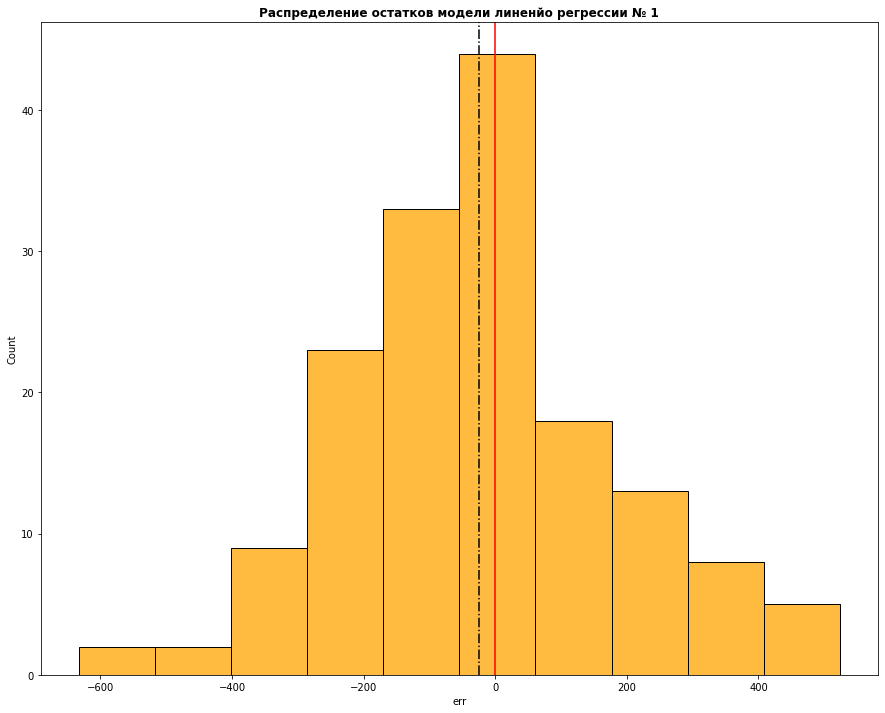

In [96]:
plt.figure(figsize = (15, 12))
plt.title('Распределение остатков модели линенйо регрессии № 1', fontweight='bold')
plt.axvline(x = 0, color = 'r', linestyle = '-')
plt.axvline(x = ml_err_1['err'].mean(), color = 'black', linestyle = '-.')
sns.histplot(ml_err_1['err'], ec='black', bins=10, color='orange')
plt.show()

In [97]:
ml_err_1.describe().T

,count,mean,std,min,25%,50%,75%,max
y_test,157.0,6141.656051,452.625527,5242.000000,5763.000000,6158.000000,6517.000000,7052.000000
y_pred,157.0,6167.029337,390.094175,5025.209679,5848.777255,6293.923526,6463.980326,6764.996909
err,157.0,-25.373286,208.615463,-632.814111,-164.145968,-34.294516,108.696566,523.551641


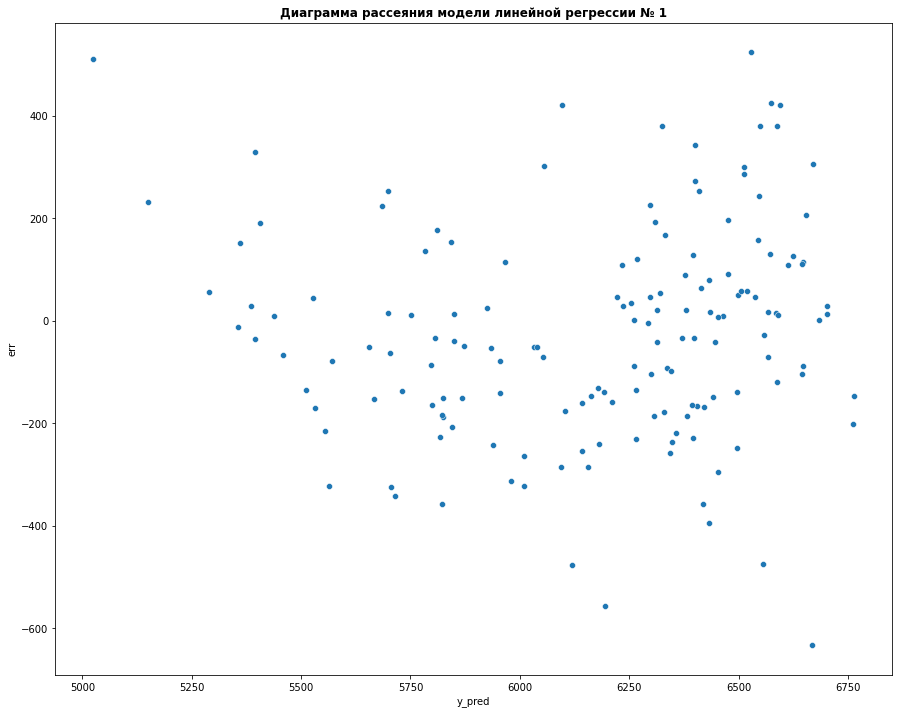

In [98]:
plt.figure(figsize = (15, 12))
plt.title('Диаграмма рассеяния модели линейной регрессии № 1', fontweight='bold')
sns.scatterplot(x='y_pred', y='err', data=ml_err_1)
plt.show()

- Значение r^2 получилось 0.7844078173416967. Данное значение говорит нам о том, что модель ошибается, примерно в 22% случаев. Это достаточно хорошее значение для модели, но ее можно улучшить. Займемся этим в следующих этапах. 

- График распределения остатков первой модели имеет распределение, похожее на нормальное и асимметричен относительно нуля. Среднее значение остатков равно -25.373286. Гистограмма немного уходит влево. Это показывает не идельность предсказания значений. Модель может их немого занижать.

- По диаграмме рассеяния модели мы наблюдаем, что уровень дисперсии в данном случае не имеет постоянного значения и увеличивается при высоких значениях. 

#### Модель № 2

Графики показывают, что СПО и Удой связаны нелинейно. Исключите нелинейность: переведите СПО в категориальный признак, выявив и использовав границу нелинейности. Границу нелинейности можно определить, взглянув на диаграмму рассеяния СПО в шаге "Корреляционный анализ". Возьмем следующие границы:

- 0 - до 91
- 1 - до 97

In [99]:
df_ferma_main['sugar_protein_ratio_cat'] = df_ferma_main['sugar_protein_ratio'].apply(lambda x: 0 if x <= 0.91 else 1)

Проверим полученные результаты.

In [100]:
df_ferma_main[['sugar_protein_ratio', 'sugar_protein_ratio_cat']].head()

,sugar_protein_ratio,sugar_protein_ratio_cat
0,0.890,0
1,0.890,0
2,0.885,0
3,0.885,0
4,0.885,0


ЭКЕ и Удой также связаны нелинейно. Исключите нелинейность: введите новую признак «ЭКЕ в квадрате».

In [101]:
df_ferma_main['energy_feed_unit^2'] = df_ferma_main['energy_feed_unit']**2

In [102]:
df_ferma_main[['energy_feed_unit', 'energy_feed_unit^2']].head()

,energy_feed_unit,energy_feed_unit^2
0,14.2,201.64
1,12.8,163.84
2,14.0,196.00
3,12.4,153.76
4,12.8,163.84


Построим модель линейной регрессии с учётом нового признака. 

In [103]:
# Разделим данные на тренировочную и тестовую выборки
X_2 = df_ferma_main[[
    'energy_feed_unit^2', 'raw_protein', 'sugar_protein_ratio_cat', 'breed', 'breed_of_dad_bull', 'type_of_pasture', 'age']]
y_2 = df_ferma_main['milk_yield']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2,
    y_2,
    random_state=RANDOM_STATE
)

In [104]:
X_train_2, X_test_2, ohe_fit_2 = ml_ohe_encoder(X_train_2, X_test_2, [
    'breed', 'breed_of_dad_bull', 'type_of_pasture', 'age', 'sugar_protein_ratio_cat'])

In [105]:
X_train_2, X_test_2, st_scaler_2 = ml_st_scaler(X_train_2, X_test_2, ['energy_feed_unit^2', 'raw_protein'])

In [106]:
model_lr_2 = LinearRegression()

In [107]:
# Построим модель линейной регресси № 2
model_lr_2 = model_lr_2.fit(X_train_2, y_train_2)

y_pred_2 = model_lr_2.predict(X_test_2)

r2_lr_2 = r2_score(y_test_2, y_pred_2)
print('r^2=', r2_lr_2)

r^2= 0.8180879926867504


In [108]:
ml_err_2 = error_table(y_test_2, y_pred_2)
ml_err_2

,y_test,y_pred,err
0,5980,5944.278142,35.721858
1,6512,6466.655661,45.344339
2,5392,5518.937220,-126.937220
3,5604,5621.103104,-17.103104
4,5667,5871.197725,-204.197725
...,...,...,...
152,6686,6738.078748,-52.078748
153,6967,6581.308849,385.691151
154,6248,6502.184832,-254.184832
155,5640,6049.464475,-409.464475


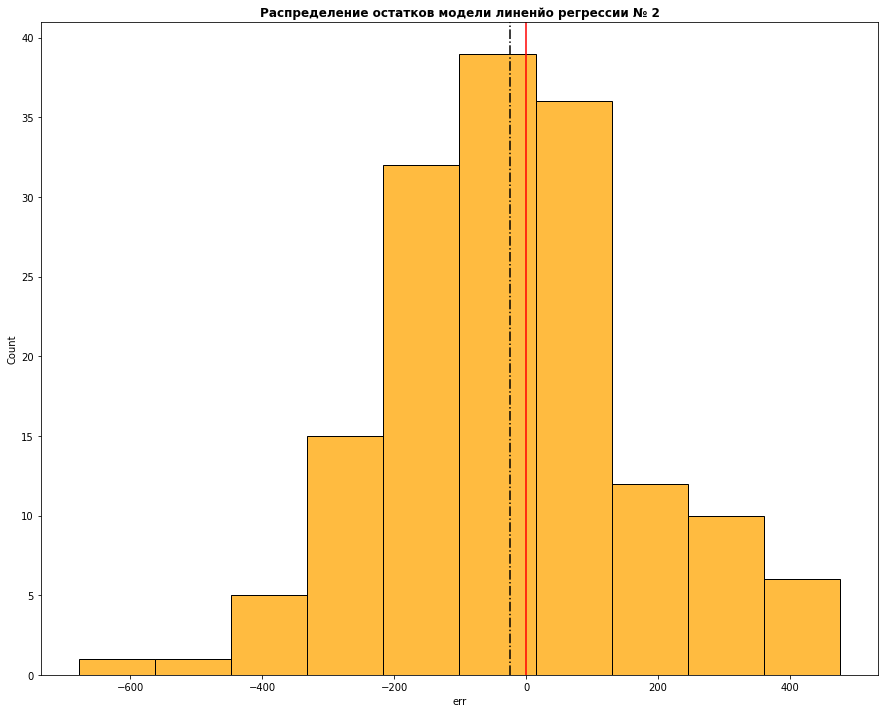

In [109]:
plt.figure(figsize = (15, 12))
plt.title('Распределение остатков модели линенйо регрессии № 2', fontweight='bold')
plt.axvline(x = 0, color = 'r', linestyle = '-')
plt.axvline(x = ml_err_2['err'].mean(), color = 'black', linestyle = '-.')
sns.histplot(ml_err_2['err'], ec='black', bins=10, color='orange')
plt.show()

In [110]:
ml_err_2.describe().T

,count,mean,std,min,25%,50%,75%,max
y_test,157.0,6141.656051,452.625527,5242.000000,5763.000000,6158.000000,6517.000000,7052.000000
y_pred,157.0,6166.028849,402.304291,5228.929390,5821.056512,6318.480834,6501.198807,6738.078748
err,157.0,-24.372798,191.495294,-677.411878,-147.957591,-27.871259,60.191976,475.458320


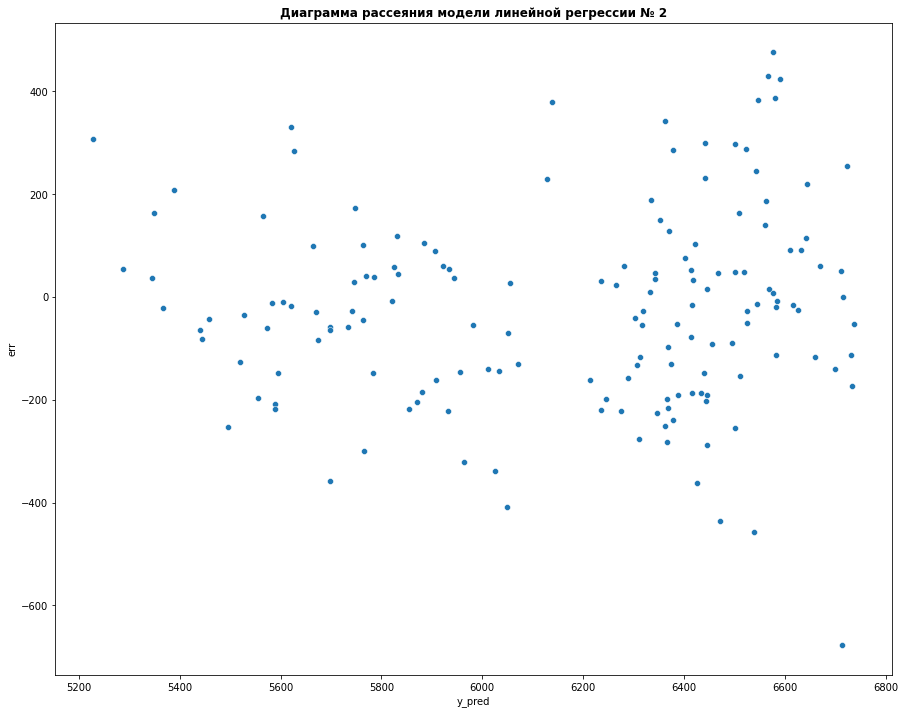

In [111]:
plt.figure(figsize = (15, 12))
plt.title('Диаграмма рассеяния модели линейной регрессии № 2', fontweight='bold')
sns.scatterplot(x='y_pred', y='err', data=ml_err_2)
plt.show()

- Значение r^2 получилось 0.8180879926867504. Данное значение говорит нам о том, что модель ошибается, примерно в 18% случаев. Качество модели явно улучшилось. Попробуем улучшить данный показатель в след. шаге.

- График распределения остатков первой модели имеет распределение, похожее на нормальное и асимметричен относительно нуля. Среднее значение остатков равно -24.372798. Данный показатель стал ближе к 0, ч/то говорит о том, что данная модель получилось более качественной

- По диаграмме рассеяния модели мы наблюдаем, что уровень дисперсии все так же не имеет постоянного значения и увеличивается при высоких значениях. 

#### Модель № 3

Построим модель линейной регрессии с учётом нового признака из файла ferma_dad.csv

Данный показатель был добавлен в df ранее, но не учитывался в предыдущих этапах. Добавим его в новую модель.

In [112]:
X_3 = df_ferma_main[['energy_feed_unit^2', 'raw_protein', 'sugar_protein_ratio_cat', 'breed', 'breed_of_dad_bull', 'type_of_pasture', 'age', 'name_dad']]
y_3 = df_ferma_main['milk_yield']
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3,
    y_3,
    random_state=RANDOM_STATE
)

In [113]:
X_train_3, X_test_3, ohe_fit_3 = ml_ohe_encoder(X_train_3, X_test_3, ['breed', 'breed_of_dad_bull', 'type_of_pasture', 'age', 'sugar_protein_ratio_cat', 'name_dad'])

In [114]:
X_train_3, X_test_3, st_scaler_3 = ml_st_scaler(X_train_3, X_test_3, ['energy_feed_unit^2', 'raw_protein'])

In [115]:
model_lr_3 = LinearRegression()

In [116]:
# Построим модель линейной регресси № 3
model_lr_3 = model_lr_3.fit(X_train_3, y_train_3)

y_pred_3 = model_lr_3.predict(X_test_3)

r2_lr_3 = r2_score(y_test_3, y_pred_3)
print('r^2=', r2_lr_3)

r^2= 0.8247542745210406


In [117]:
ml_err_3 = error_table(y_test_3, y_pred_3)
ml_err_3

,y_test,y_pred,err
0,5980,6013.248427,-33.248427
1,6512,6488.055642,23.944358
2,5392,5552.535828,-160.535828
3,5604,5589.054745,14.945255
4,5667,5868.928992,-201.928992
...,...,...,...
152,6686,6472.342487,213.657513
153,6967,6619.752228,347.247772
154,6248,6509.388880,-261.388880
155,5640,6107.581382,-467.581382


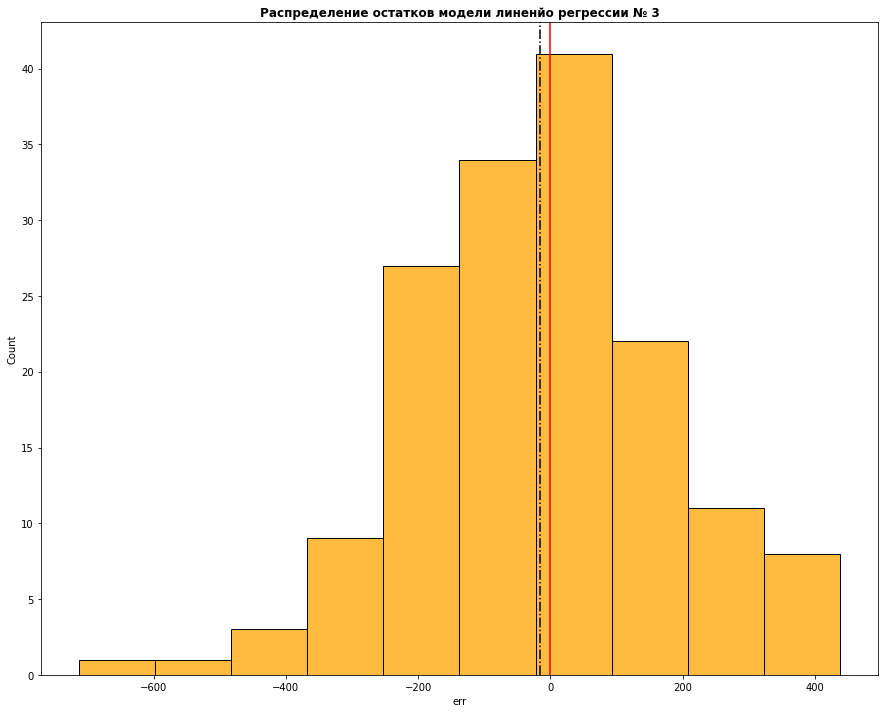

In [118]:
plt.figure(figsize = (15, 12))
plt.title('Распределение остатков модели линенйо регрессии № 3', fontweight='bold')
plt.axvline(x = 0, color = 'r', linestyle = '-')
plt.axvline(x = ml_err_3['err'].mean(), color = 'black', linestyle = '-.')
sns.histplot(ml_err_3['err'], ec='black', bins=10, color='orange')
plt.show()

In [119]:
ml_err_3.describe().T

,count,mean,std,min,25%,50%,75%,max
y_test,157.0,6141.656051,452.625527,5242.000000,5763.000000,6158.000000,6517.000000,7052.000000
y_pred,157.0,6156.857573,412.457539,5220.051086,5773.772717,6307.130336,6476.967703,6800.435734
err,157.0,-15.201522,188.865034,-712.793903,-144.381634,-15.967703,112.027110,437.597704


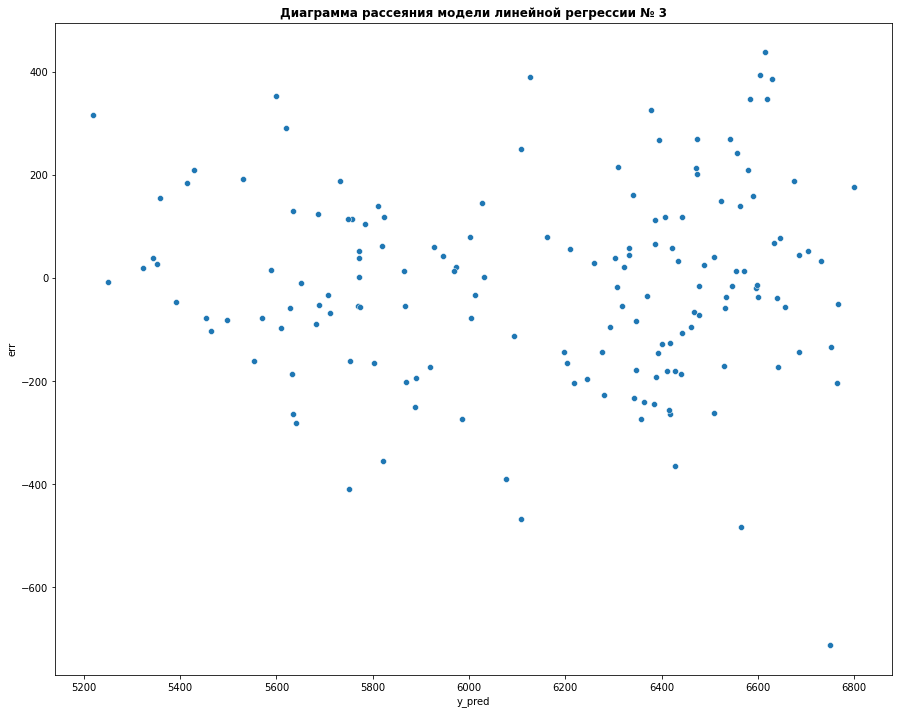

In [120]:
plt.figure(figsize = (15, 12))
plt.title('Диаграмма рассеяния модели линейной регрессии № 3', fontweight='bold')
sns.scatterplot(x='y_pred', y='err', data=ml_err_3)
plt.show()

- Значение r^2 немного увеличилось и стало 0.8247542745210406. Модель стала работать лучше.
- Среднее значение ошибки сильно изменилось и стало равно -15.201522. График явно смещен влево.
- По диаграмме рассеяния модели мы наблюдаем, что уровень дисперсии все так же не имеет постоянного значения и увеличивается при высоких значениях.

Сравним полученые нами модели

In [121]:
model_lr_1_table = [r2_lr_1, 
                     mean_squared_error(y_test_1, y_pred_1), 
                     mean_squared_error(y_test_1, y_pred_1, squared=False), 
                     mean_absolute_error(y_test_1, y_pred_1)
                   ]
model_lr_2_table = [r2_lr_2, 
                     mean_squared_error(y_test_2, y_pred_2), 
                     mean_squared_error(y_test_2, y_pred_2, squared=False), 
                     mean_absolute_error(y_test_2, y_pred_2)
                   ]
model_lr_3_table = [r2_lr_3, 
                     mean_squared_error(y_test_3, y_pred_3), 
                     mean_squared_error(y_test_3, y_pred_3, squared=False), 
                     mean_absolute_error(y_test_3, y_pred_3)
                   ]

models_lr_table = pd.DataFrame(data=[model_lr_1_table, model_lr_2_table, model_lr_3_table], 
                                 index=['model_1', 'model_2', 'model_3'], 
                                 columns=['R2', 'MSE', 'RMSE', 'MAE'])
models_lr_table

,R2,MSE,RMSE,MAE
model_1,0.784408,43887.015010,209.492279,164.241945
model_2,0.818088,37030.911311,192.434174,149.039652
model_3,0.824754,35673.889886,188.875329,146.163024


Из полученной информации можно сделать вывод, что лучше всего с предсказанием справляетя модель под номером 3. У нее получились более качественные метрики и она имеет меньший показатель корня средней квадратичной ошибки. 

Выведим доверительный интервал для нашей модели

In [122]:
st.t.interval(alpha=0.95, df=len(y_pred_3)-1, loc=np.mean(y_pred_3), scale=st.sem(y_pred_3))

/tmp/ipykernel_284/2885889067.py:1: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(y_pred_3)-1, loc=np.mean(y_pred_3), scale=st.sem(y_pred_3))


(6091.835660789231, 6221.879485123438)

#### Прогноз удоя

В таблицу df_cow_buy необходимо добавить признаки для предсказания.

In [123]:
for name in ['raw_protein', 'energy_feed_unit', 'sugar_protein_ratio']:
    df_cow_buy[name] = df_ferma_main[name].mean() * 1.05

df_cow_buy['sugar_protein_ratio_cat'] = df_cow_buy['sugar_protein_ratio'].apply(lambda x: 0 if x <= 0.91 else 1)
df_cow_buy['energy_feed_unit^2'] = df_cow_buy['energy_feed_unit']**2
df_cow_buy

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age,raw_protein,energy_feed_unit,sugar_protein_ratio,sugar_protein_ratio_cat,energy_feed_unit^2
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138
6,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
7,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138
8,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138
9,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138


In [124]:
df_cow_buy['type_of_pasture'] = df_cow_buy['type_of_pasture'].replace('холмистое', 'Холмистое')
df_cow_buy['type_of_pasture'] = df_cow_buy['type_of_pasture'].replace('равнинное', 'Равнинное')

In [125]:
cat_col = ['breed', 'breed_of_dad_bull', 'type_of_pasture', 'age', 'sugar_protein_ratio_cat', 'name_dad']
df_cow_buy_ohe = ohe_fit_3.transform(df_cow_buy[cat_col])
df_cow_buy_ohe = pd.DataFrame(df_cow_buy_ohe, columns=ohe_fit_3.get_feature_names())
df_cow_buy_test = df_cow_buy.reset_index(drop=True).join(df_cow_buy_ohe).drop(cat_col, axis=1)

In [126]:
num_col = ['energy_feed_unit^2', 'raw_protein']
df_cow_buy_test_scal = st_scaler_3.transform(df_cow_buy_test[num_col])

st_col = []
for col in num_col:
    st_col.append(f'{col}_st')

df_cow_buy_test_scal = pd.DataFrame(df_cow_buy_test_scal, columns=st_col)
    
        
for col in num_col:
    df_cow_buy_test[col] = df_cow_buy_test_scal[f'{col}_st']

In [127]:
df_cow_buy_test = df_cow_buy_test.drop(['current_fatness', 'current_level_of_the_protein', 'energy_feed_unit', 'sugar_protein_ratio'], axis=1)

In [128]:
df_cow_buy_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   raw_protein         16 non-null     float64
 1   energy_feed_unit^2  16 non-null     float64
 2   x0_РефлешнСоверинг  16 non-null     float64
 3   x1_Соверин          16 non-null     float64
 4   x2_Холмистое        16 non-null     float64
 5   x3_менее_2_лет      16 non-null     float64
 6   x4_1                16 non-null     float64
 7   x5_Буйный           16 non-null     float64
 8   x5_Геркулес         16 non-null     float64
 9   x5_Соловчик         16 non-null     float64
dtypes: float64(10)
memory usage: 1.4 KB


In [129]:
y_pred_3 = model_lr_3.predict(df_cow_buy_test)

data_y_pred_3 = pd.Series(y_pred_3)

In [130]:
df_cow_buy['milk_yield'] = data_y_pred_3
df_cow_buy['milk_yield']

0     6607.175429
1     6375.967160
2     6281.255907
3     6590.345509
4     6539.402198
5     6422.636350
6     6568.515869
7     6397.796800
8     6341.963992
9     6615.185058
10    6607.175429
11    6124.730874
12    6590.345509
13    6341.963992
14    6422.636350
15    6568.515869
Name: milk_yield, dtype: float64

#### Вывод

Мы смогли с помощью нашей лучшей модели предсказать удой для коров, которые предлагает для нашего фермера "ЭкоФерма".

По итогам, модель предсказывает, что каждая корова сможет дать более 6000 литров молока в год.

## Обучение модели логистической регрессии

Целевой признак - Вкус молока taste_of_milk

Для обучения будем использовать входные признаки, которые могут повлиять на целевой признак. В данном случае на вкус молока могут повлиять такие признаки, как: 


- ЭКЕ (Энергетическая кормовая единица) energy_feed_unit
- Сырой протеин (raw_protein)
- СПО (Сахаро-протеиновое соотношение) sugar_protein_ratio

Так же используем признаки самой коровы:

- Порода коровы breed
- Возраст age

И еще рассмотрим признаки содержания молока:
- Жирность fat_content
- Белок protein

In [131]:
df_ferma_main.head()

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,type_of_pasture,breed_of_dad_bull,fat_content,protein,taste_of_milk,age,name_dad,sugar_protein_ratio_cat,energy_feed_unit^2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин,0,163.84


В ходе работы над построением метрик возникла ошибка, поэтому хочется сразу явно обозначить вкус молока для бепроблемного построения метрик. 

- 1 - вкусно
- 0 - не вкусно

In [132]:
df_ferma_main['taste_of_milk'] = df_ferma_main['taste_of_milk'].replace('вкусно', 1)
df_ferma_main['taste_of_milk'] = df_ferma_main['taste_of_milk'].replace('не вкусно', 0)

Создадим обучающие и тестовые выборки.

In [133]:
X_4 = df_ferma_main[['energy_feed_unit', 'energy_feed_unit^2', 'raw_protein', 'sugar_protein_ratio','sugar_protein_ratio_cat', 'breed', 'fat_content', 'protein', 'age']]
y_4 = df_ferma_main['taste_of_milk']
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_4,
    y_4,
    random_state=RANDOM_STATE
    )

Нормализуем категориальные признаки.

In [134]:
X_train_4, X_test_4, ohe_fit_4 = ml_ohe_encoder(X_train_4, X_test_4, ['sugar_protein_ratio_cat', 'breed', 'age'])

Масштабируем количественные признаки.

In [135]:
X_train_4, X_test_4, st_scaler_4 = ml_st_scaler(X_train_4, X_test_4, ['energy_feed_unit', 'energy_feed_unit^2', 'sugar_protein_ratio', 'raw_protein', 'fat_content', 'protein'])

Построим модель логистической регрессии.

In [136]:
clf = LogisticRegression(random_state = RANDOM_STATE)

clf = clf.fit(X_train_4, y_train_4)

y_pred_4 = clf.predict(X_test_4)

Расчитаем метрики для анализа модели.

In [137]:
accuracy = accuracy_score(y_test_4, y_pred_4)
precision = precision_score(y_test_4, y_pred_4)
recall = recall_score(y_test_4, y_pred_4)

print(f'accuracy: {round(accuracy ,2)}',f'precision: {round(precision ,2)}', f'recall: {round(recall ,2)}', sep = '\n')

accuracy: 0.66
precision: 0.64
recall: 0.89


Наша модель имеет достатчно сдержанные показатели точности.

Необходимо построить матрицу ошибок.

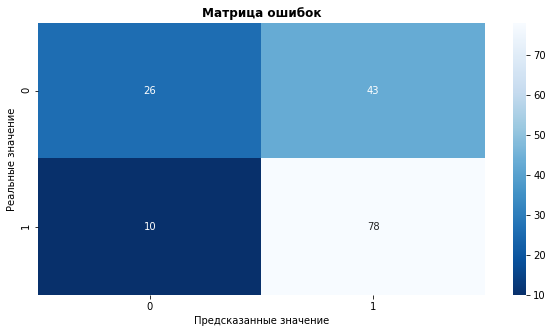

In [138]:
plt.figure(figsize = (10, 5))
conf_matrix = confusion_matrix(y_test_4, y_pred_4)
plt.title('Матрица ошибок', fontweight='bold')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные значение')
plt.xlabel('Предсказанные значение')
plt.show()

Перед нами стоит задача получить вкусное молоко. Модель должна минимизировать ошибку первого рода. Для ошибки первого рода идеально подходит метрика precision. Она реагирует на ошибки первого рода, однако не реагирует на ошибки второго.

Сведем критичную ошибку к нулю.

In [139]:
y_proba_4 = clf.predict_proba(X_test_4)[:,1]

data = pd.DataFrame(zip(y_test_4, y_proba_4),
             columns = ['y_valid', 'y_proba'])

data.head()

,y_valid,y_proba
0,1,0.565865
1,1,0.702509
2,1,0.386802
3,0,0.464317
4,1,0.742581


In [140]:
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 50,endpoint=False)]
print(thresholds) 

[0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [141]:
prec = {}

for i in thresholds:
    data['y_pred_'+ str(i)] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)
    precision = precision_score(data['y_valid'], data['y_pred_'+ str(i)], zero_division=0)
    prec[i] = precision

In [142]:
 prec

{0.5: 0.6446280991735537,
 0.51: 0.6470588235294118,
 0.52: 0.6581196581196581,
 0.53: 0.6666666666666666,
 0.54: 0.6846846846846847,
 0.55: 0.6880733944954128,
 0.56: 0.6952380952380952,
 0.57: 0.693069306930693,
 0.58: 0.7263157894736842,
 0.59: 0.7282608695652174,
 0.6: 0.7444444444444445,
 0.61: 0.7317073170731707,
 0.62: 0.7466666666666667,
 0.63: 0.75,
 0.64: 0.7681159420289855,
 0.65: 0.7611940298507462,
 0.66: 0.7777777777777778,
 0.67: 0.7741935483870968,
 0.68: 0.8,
 0.69: 0.7777777777777778,
 0.7: 0.7906976744186046,
 0.71: 0.7567567567567568,
 0.72: 0.71875,
 0.73: 0.7142857142857143,
 0.74: 0.7307692307692307,
 0.75: 0.631578947368421,
 0.76: 0.5625,
 0.77: 0.5,
 0.78: 0.5454545454545454,
 0.79: 0.6,
 0.8: 0.5714285714285714,
 0.81: 0.8,
 0.82: 1.0,
 0.83: 1.0,
 0.84: 1.0,
 0.85: 1.0,
 0.86: 1.0,
 0.87: 0.0,
 0.88: 0.0,
 0.89: 0.0,
 0.9: 0.0,
 0.91: 0.0,
 0.92: 0.0,
 0.93: 0.0,
 0.94: 0.0,
 0.95: 0.0,
 0.96: 0.0,
 0.97: 0.0,
 0.98: 0.0,
 0.99: 0.0}

В данном случе, я хочу взять порог, равный 0.68, т.к. это самое оптимальное значение, при котором мы имеем максимальное значение метрики preccision. Порог от 0.82 до 0.86 является слишком большим значением.

In [143]:
data = data[['y_valid', 'y_proba', 'y_pred_0.68']]

In [144]:
accuracy_068 = accuracy_score(y_test_4, data['y_pred_0.68'])
precision_068 = precision_score(y_test_4, data['y_pred_0.68'])
recall_068 = recall_score(y_test_4, data['y_pred_0.68'])

print(f'accuracy: {round(accuracy_068 ,2)}',f'precision: {round(precision_068 ,2)}', f'recall: {round(recall_068 ,2)}', sep = '\n')

accuracy: 0.67
precision: 0.8
recall: 0.55


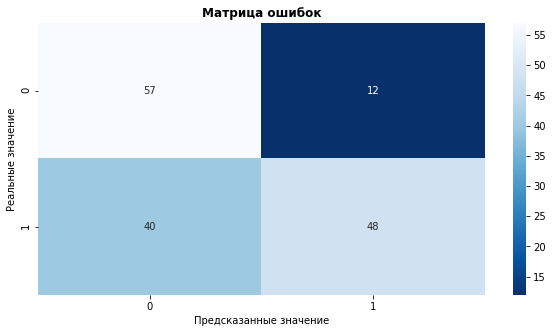

In [146]:
plt.figure(figsize = (10, 5))
conf_matrix = confusion_matrix(y_test_4, data['y_pred_0.68'])
plt.title('Матрица ошибок', fontweight='bold')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные значение')
plt.xlabel('Предсказанные значение')
plt.show()

Мы добились необходимного результат. Модель стала предсказывать немного меньше верных значений, но при этом она практически не допускает ошибок первого рода, что подходит для целей поставленной перед нами задачей.

#### Прогноз целевого признака "Вкус молока"

In [147]:
cat_col = ['sugar_protein_ratio_cat', 'breed', 'age']
df_cow_buy_ohe_taste = ohe_fit_4.transform(df_cow_buy[cat_col])
df_cow_buy_ohe_taste = pd.DataFrame(df_cow_buy_ohe_taste, columns=ohe_fit_4.get_feature_names())
df_cow_buy_taste = df_cow_buy.reset_index(drop=True).join(df_cow_buy_ohe_taste).drop(cat_col, axis=1)

In [148]:
df_cow_buy_taste = df_cow_buy_taste.drop(['type_of_pasture', 'breed_of_dad_bull', 'name_dad', 'milk_yield'], axis = 1)

In [149]:
df_cow_buy_taste

,current_fatness,current_level_of_the_protein,raw_protein,energy_feed_unit,sugar_protein_ratio,energy_feed_unit^2,x0_1,x1_РефлешнСоверинг,x2_менее_2_лет
0,3.58,3.076,2019.947532,15.276162,0.958744,233.361138,1.0,0.0,0.0
1,3.54,3.081,2019.947532,15.276162,0.958744,233.361138,1.0,0.0,1.0
2,3.59,3.074,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,0.0
3,3.40,3.061,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,0.0
4,3.64,3.074,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,0.0
5,3.63,3.053,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,1.0
6,3.57,3.079,2019.947532,15.276162,0.958744,233.361138,1.0,0.0,0.0
7,3.40,3.079,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,1.0
8,3.73,3.055,2019.947532,15.276162,0.958744,233.361138,1.0,0.0,0.0
9,3.73,3.073,2019.947532,15.276162,0.958744,233.361138,1.0,1.0,0.0


In [150]:
num_col = ['energy_feed_unit', 'energy_feed_unit^2', 'sugar_protein_ratio', 'raw_protein', 'current_fatness', 'current_level_of_the_protein']
df_cow_buy_taste_scal = st_scaler_4.transform(df_cow_buy_taste[num_col])

st_col = []
for col in num_col:
    st_col.append(f'{col}_st')

df_cow_buy_taste_scal = pd.DataFrame(df_cow_buy_taste_scal, columns=st_col)
    
        
for col in num_col:
    df_cow_buy_taste[col] = df_cow_buy_taste_scal[f'{col}_st'] 

In [151]:
taste_milk = clf.predict(df_cow_buy_taste)

taste_milk_proba = clf.predict_proba(df_cow_buy_taste)[:,1]

In [152]:
taste_milk_proba = pd.Series(taste_milk_proba)

In [153]:
df_cow_buy['taste_milk'] = taste_milk_proba
df_cow_buy = df_cow_buy.sort_values(by='taste_milk', ascending=False)
df_cow_buy

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age,raw_protein,energy_feed_unit,sugar_protein_ratio,sugar_protein_ratio_cat,energy_feed_unit^2,milk_yield,taste_milk
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6375.967160,0.784613
7,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6397.796800,0.746943
6,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6568.515869,0.726765
13,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6341.963992,0.684007
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6607.175429,0.544816
11,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6124.730874,0.469034
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6281.255907,0.444286
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6539.402198,0.428453
9,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6615.185058,0.339407
15,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6568.515869,0.206787


In [155]:
answer = df_cow_buy[df_cow_buy['taste_milk'] > 0.68]
answer

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age,raw_protein,energy_feed_unit,sugar_protein_ratio,sugar_protein_ratio_cat,energy_feed_unit^2,milk_yield,taste_milk
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6375.967160,0.784613
7,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6397.796800,0.746943
6,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6568.515869,0.726765
13,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6341.963992,0.684007


Наша модель смогла предсказать, что вкусное молоко может получиться у 4 коров, которые хотят продать "ЭкоФерма". Эти коровы предствлены выше.

## Итоговые выводы

In [162]:
answer

,breed,type_of_pasture,breed_of_dad_bull,name_dad,current_fatness,current_level_of_the_protein,age,raw_protein,energy_feed_unit,sugar_protein_ratio,sugar_protein_ratio_cat,energy_feed_unit^2,milk_yield,taste_milk
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6375.967160,0.784613
8,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6397.796800,0.746943
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6568.515869,0.726765
14,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,2019.947532,15.276162,0.958744,1,233.361138,6341.963992,0.684007


В рамках данной работы была построена модель, которая показала, что фермер сможет купить 4 коров, представленных "ЭкоФермой" которые смогут давать не менее 6000 литров молока в год и при этом, чтобы молоко у этих коров соответствовало его критерию вкуса. Данный вывод был получен на основе предоставленных данных самих фермером о его собственных коровах и на основании данных, представленных компанией "ЭкоФерма".

Стоит отмеить некоторые факты, которые были получены на этапе корреляционного анализа:

- На удой очень сильно влияют такие показатели, как ЭКО и СПО. 
- Более явная корреляция Вкуса молока наблюдается только с признаком СПО. 



#### Выводы о модели линейной регрессии

- Для улучшения качества модели линейной регрессии была исключена нелинейная взаимосвязь между целевым признаком Удой в входными признаками ЭКО и СПО. Показатели ЭКО были возведены в квадрат, а СПО прошел процесс категоризации и был разделен на две группы. Помимо этого в модель был добавлен новый входной признак Имя быка-папы, который помог добииться максимальной точности модели.
- Чтобы добиться лучших показателей для модели линейной регрессии, необходимо добавить больше входных признаков, либо увеличить саму выборку

Показатели нашей модели представлю ниже:

In [163]:
models_lr_table

,R2,MSE,RMSE,MAE
model_1,0.784408,43887.015010,209.492279,164.241945
model_2,0.818088,37030.911311,192.434174,149.039652
model_3,0.824754,35673.889886,188.875329,146.163024


#### Выводы о модели логистической регрессии

Для точности модели логистической регрессии важно понимать контекст и цель нашей задачи. В данном случае, нам необходимо было, чтобы модель более точно предсказывала, что молоко получится ИМЕННО вкусным. То есть, нам необходимо было минимизировать кол-во ошибок первого рода